In [28]:
!pip install arch
from arch import arch_model


In [33]:
"""
Hybrid GARCH(1,1) + Conv1d Neural Network Model with Dynamic Volatility Layer

The NN learns a persistence parameter C = α + β and a split factor ρ from historical data.
From (C, ρ) it reconstructs (α, β), which are then passed with ω to a differentiable GARCH
layer to predict the next conditional variance.

This implementation includes:
- Proper train/validation/test split
- Global standardisation of returns before NN and arch_model
- Training on log-variance log(σ²) instead of raw σ²
- Extensive diagnostic visualizations
- Parameter learning tracking over epochs
- Extra plots: α_true vs α_pred on train / val / test
"""

from arch import arch_model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, List

# ============================================================================
# 1. DATA GENERATION: GARCH(1,1) Process
# ============================================================================

class GARCHGenerator:
    """
    PyTorch-based GARCH(1,1) data generator.

    GARCH(1,1) recursion:
        σ²_t = ω + α·r²_{t-1} + β·σ²_{t-1}
        r_t = σ_t·ε_t, where ε_t ~ N(0,1)
    """

    def __init__(self, omega: float, alpha: float, beta: float,
                 n_samples: int, seed: int = 42):
        """
        Args:
            omega: Constant term (ω > 0)
            alpha: ARCH coefficient (α ≥ 0)
            beta: GARCH coefficient (β ≥ 0)
            n_samples: Number of time steps to generate
            seed: Random seed for reproducibility
        """
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.n_samples = n_samples

        # Verify stationarity: α + β < 1
        assert alpha + beta < 1.0, f"Non-stationary: α + β = {alpha + beta} >= 1"
        assert omega > 0 and alpha >= 0 and beta >= 0, "Parameters must be positive"

        torch.manual_seed(seed)

    def generate_series(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Generate complete time series.

        Returns:
            tuple: (returns, conditional_variances) as torch tensors
        """
        # Initialize with unconditional variance
        sigma2 = self.omega / (1.0 - self.alpha - self.beta)
        r_prev = 0.0

        returns = []
        variances = []

        for _ in range(self.n_samples):
            # GARCH recursion
            sigma2 = self.omega + self.alpha * (r_prev ** 2) + self.beta * sigma2
            variances.append(sigma2)

            # Generate return
            epsilon = torch.randn(1).item()
            r_t = np.sqrt(sigma2) * epsilon
            returns.append(r_t)

            r_prev = r_t

        return torch.tensor(returns, dtype=torch.float32), \
               torch.tensor(variances, dtype=torch.float32)


# ============================================================================
# 1.Bis: recompute σ² from params (for arch_model comparison)
# ============================================================================

def compute_garch_variance_from_params(returns: np.ndarray,
                                       omega: float,
                                       alpha: float,
                                       beta: float) -> np.ndarray:
    """
    Recompute conditional variances σ_t^2 from returns and GARCH(1,1) params.
    returns: array of shape [T]
    """
    T = len(returns)
    sigma2 = np.zeros(T)
    # Unconditional variance as starting point
    denom = max(1e-4, 1.0 - alpha - beta)
    sigma2[0] = omega / denom

    for t in range(1, T):
        sigma2[t] = omega + alpha * (returns[t-1]**2) + beta * sigma2[t-1]

    return sigma2


# ============================================================================
# 2. NEURAL NETWORK FOR PARAMETER PREDICTION
# ============================================================================

class GARCHParameterNet(nn.Module):
    """
    Neural network that learns to predict:
      - a level parameter ω > 0,
      - a persistence parameter C = α + β ∈ (0, C_max),
      - a split factor ρ ∈ (0, 1) such that α = Cρ and β = C(1−ρ),

    from historical returns. The resulting (ω, α, β) are then used in a GARCH(1,1)
    recursion to produce one-step-ahead conditional variances.

    Architecture: 1D convolutional encoder → MLP → (ω, C, ρ) heads with constraints.
    """

    def __init__(self, input_seq_len: int, hidden_dim: int = 64,
                 num_conv_layers: int = 2, kernel_size: int = 5):
        super(GARCHParameterNet, self).__init__()

        self.input_seq_len = input_seq_len
        self.hidden_dim = hidden_dim

        # --- Temporal encoder with 1D convolutions ---
        padding = kernel_size // 2  # keep same length T

        convs = []
        in_channels = 1
        for _ in range(num_conv_layers):
            convs.append(
                nn.Conv1d(
                    in_channels=in_channels,
                    out_channels=hidden_dim,
                    kernel_size=kernel_size,
                    padding=padding
                )
            )
            convs.append(nn.ReLU())
            in_channels = hidden_dim

        self.conv_net = nn.Sequential(*convs)

        # --- MLP for parameter prediction ---
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

        # Heads:
        #   - omega_head : level parameter ω > 0
        #   - c_head     : persistence C = α+β in (0, C_max)
        #   - rho_head   : split factor ρ in (0,1) so α = Cρ, β = C(1-ρ)
        self.omega_head = nn.Linear(hidden_dim // 2, 1)
        self.c_head     = nn.Linear(hidden_dim // 2, 1)
        self.rho_head   = nn.Linear(hidden_dim // 2, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights with Xavier for conv & linear layers."""
        for name, param in self.named_parameters():
            if 'weight' in name and param.dim() >= 2:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: Input returns [batch_size, seq_len, 1]

        Returns:
            tuple: (ω, α, β) as torch tensors [batch_size]
        """
        # x : [B, T, 1] → [B, 1, T] for Conv1d
        x = x.transpose(1, 2)  # [B, 1, T]

        # Conv1d encoder
        x = self.conv_net(x)   # [B, hidden_dim, T]

        # Global average pooling over time
        x = x.mean(dim=2)      # [B, hidden_dim]

        # MLP
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))  # [B, hidden_dim // 2]

        # Raw parameters
        omega_raw = self.omega_head(x)
        c_raw     = self.c_head(x)
        rho_raw   = self.rho_head(x)

        # ω > 0 via softplus
        omega = torch.nn.functional.softplus(omega_raw) + 1e-6

        # C = α+β in (0, C_max) to enforce stationarity
        C_max = 0.99                   # persistence upper bound < 1
        C = torch.sigmoid(c_raw) * C_max   # C ∈ (0, C_max)

        # ρ in (0,1) controls how C is split between α and β
        rho = torch.sigmoid(rho_raw)       # ρ ∈ (0,1)

        # α = Cρ, β = C(1−ρ) ⇒ α ≥ 0, β ≥ 0, α+β = C < 1
        alpha = C * rho
        beta  = C * (1.0 - rho)

        return omega.squeeze(-1), alpha.squeeze(-1), beta.squeeze(-1)


# ============================================================================
# 3. DIFFERENTIABLE GARCH VOLATILITY LAYER
# ============================================================================

class GARCHVolatilityLayer(nn.Module):
    """
    Differentiable GARCH layer that computes conditional variance recursively.

    This layer embeds memory (past shocks and past variance) directly into
    the forward pass, similar to recurrent architectures.
    """

    def __init__(self):
        super(GARCHVolatilityLayer, self).__init__()

    def forward(self, returns_window: torch.Tensor, omega: torch.Tensor,
                alpha: torch.Tensor, beta: torch.Tensor) -> torch.Tensor:
        """
        Compute conditional variance using GARCH recursion.

        Args:
            returns_window: Past returns [batch_size, seq_len, 1]
            omega: ω parameter [batch_size]
            alpha: α parameter [batch_size]
            beta: β parameter [batch_size]

        Returns:
            torch.Tensor: Next conditional variance σ²_{t+1} [batch_size]
        """
        batch_size = returns_window.size(0)
        seq_len = returns_window.size(1)

        # Initialize with unconditional variance
        sigma2 = omega / (1.0 - alpha - beta + 1e-8)

        # Flatten returns for iteration
        returns_seq = returns_window.squeeze(-1)  # [batch_size, seq_len]

        # GARCH recursion: σ²_t = ω + α·r²_{t-1} + β·σ²_{t-1}
        for t in range(seq_len):
            r_t = returns_seq[:, t]
            sigma2 = omega + alpha * (r_t ** 2) + beta * sigma2

        return sigma2


# ============================================================================
# 4. HYBRID MODEL: NN + GARCH VOLATILITY LAYER
# ============================================================================

class HybridGARCHModel(nn.Module):
    """
    Hybrid model: NN learns parameters → GARCH layer computes volatility

    Flow:
        Historical returns → Parameter NN → (ω, α, β) → GARCH Layer → σ²_{t+1}
    """

    def __init__(self, input_seq_len: int, hidden_dim: int = 64):
        super(HybridGARCHModel, self).__init__()

        self.param_net = GARCHParameterNet(input_seq_len, hidden_dim)
        self.volatility_layer = GARCHVolatilityLayer()

    def forward(self, returns_window: torch.Tensor) -> Tuple[torch.Tensor,
                                                             torch.Tensor,
                                                             torch.Tensor,
                                                             torch.Tensor]:
        """
        Forward pass: predict next conditional variance.

        Args:
            returns_window: Historical returns [batch_size, seq_len, 1]

        Returns:
            tuple: (predicted_variance, omega, alpha, beta)
        """
        # Step 1: NN predicts GARCH parameters from historical data
        omega, alpha, beta = self.param_net(returns_window)

        # Step 2: GARCH layer computes conditional variance using learned parameters
        sigma2_pred = self.volatility_layer(returns_window, omega, alpha, beta)

        return sigma2_pred, omega, alpha, beta

    def param_net_only(self, returns_window):
        """
        Retourne uniquement (ω, α, β) sans calculer la variance.
        returns_window: [B, T, 1]
        """
        return self.param_net(returns_window)


# ============================================================================
# 5. DATASET WITH TRAIN/VAL/TEST SPLIT
# ============================================================================

class MultiGARCHDataset(Dataset):
    """
    Dataset for MULTIPLE GARCH time series with sliding windows.

    Inputs:
        returns_mat:   [n_series, series_len]
        variances_mat: [n_series, series_len]
    Each sample is:
        (window_of_returns, target_variance_at_t+window)
    from some series j, some starting time t.
    """

    def __init__(self, returns_mat: torch.Tensor,
                 variances_mat: torch.Tensor,
                 window_size: int):
        assert returns_mat.shape == variances_mat.shape
        self.returns = returns_mat
        self.variances = variances_mat
        self.window_size = window_size

        self.n_series, self.series_len = self.returns.shape
        self.windows_per_series = self.series_len - window_size
        self.n_samples = self.n_series * self.windows_per_series

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Map global idx -> (series_idx, time_idx)
        series_idx = idx // self.windows_per_series
        t = idx % self.windows_per_series

        # Input window: [window_size, 1]
        window = self.returns[series_idx, t:t + self.window_size].unsqueeze(-1)

        # Target variance: σ²_{t+window}
        target_var = self.variances[series_idx, t + self.window_size]

        return window, target_var





# ============================================================================
# 6. TRAINING WITH VALIDATION (LOSS ON LOG-VARIANCE)
# ============================================================================

def train_epoch(model: nn.Module, train_loader: DataLoader,
                optimizer: optim.Optimizer, criterion: nn.Module,
                device: str) -> Tuple[float, float, float, float]:
    """Train for one epoch (MSE on log-variance)."""
    model.train()
    total_loss = 0.0
    total_omega = 0.0
    total_alpha = 0.0
    total_beta = 0.0
    n_batches = 0
    eps = 1e-8

    for batch_returns, batch_target_var in train_loader:
        batch_returns = batch_returns.to(device, non_blocking=True)
        batch_target_var = batch_target_var.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward pass
        pred_var, omega, alpha, beta = model(batch_returns)

        # MSE loss between predicted and true *log-variance*
        pred_logvar = torch.log(pred_var + eps)
        true_logvar = torch.log(batch_target_var + eps)
        loss = criterion(pred_logvar, true_logvar)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Accumulate statistics
        total_loss += loss.item()
        total_omega += omega.mean().item()
        total_alpha += alpha.mean().item()
        total_beta += beta.mean().item()
        n_batches += 1

    return (total_loss / n_batches, total_omega / n_batches,
            total_alpha / n_batches, total_beta / n_batches)


def validate(model: nn.Module, val_loader: DataLoader,
             criterion: nn.Module, device: str) -> Tuple[float, float, float, float]:
    """Validate the model (MSE on log-variance)."""
    model.eval()
    total_loss = 0.0
    total_omega = 0.0
    total_alpha = 0.0
    total_beta = 0.0
    n_batches = 0
    eps = 1e-8

    with torch.no_grad():
        for batch_returns, batch_target_var in val_loader:
            batch_returns = batch_returns.to(device)
            batch_target_var = batch_target_var.to(device)

            pred_var, omega, alpha, beta = model(batch_returns)

            pred_logvar = torch.log(pred_var + eps)
            true_logvar = torch.log(batch_target_var + eps)
            loss = criterion(pred_logvar, true_logvar)

            total_loss += loss.item()
            total_omega += omega.mean().item()
            total_alpha += alpha.mean().item()
            total_beta += beta.mean().item()
            n_batches += 1

    return (total_loss / n_batches, total_omega / n_batches,
            total_alpha / n_batches, total_beta / n_batches)


def train_hybrid_garch(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    learning_rate: float,
    device: str,
    checkpoint_path: str = "best_garch_model.pt",   # ← paramétré ici
    load_best: bool = True,
) -> dict:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-7)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=10)
    criterion = nn.MSELoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_omega': [], 'train_alpha': [], 'train_beta': [],
        'val_omega': [], 'val_alpha': [], 'val_beta': []
    }

    print("Starting training...")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} "
          f"{'Train α':<10} {'Train β':<10} {'Val α':<10} {'Val β':<10}")
    print("-" * 80)

    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        # Train
        train_loss, train_omega, train_alpha, train_beta = train_epoch(
            model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_omega, val_alpha, val_beta = validate(
            model, val_loader, criterion, device)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_omega'].append(train_omega)
        history['train_alpha'].append(train_alpha)
        history['train_beta'].append(train_beta)
        history['val_omega'].append(val_omega)
        history['val_alpha'].append(val_alpha)
        history['val_beta'].append(val_beta)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)

        # Print progress
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"{epoch+1:<8} {train_loss:<12.6f} {val_loss:<12.6f} "
                  f"{train_alpha:<10.6f} {train_beta:<10.6f} "
                  f"{val_alpha:<10.6f} {val_beta:<10.6f}")

    print(f"\nTraining completed! Best validation loss (log-variance MSE): {best_val_loss:.6f}")

    # Optionnel : recharger le meilleur modèle
    if load_best:
        model.load_state_dict(torch.load(checkpoint_path))

    return history



def plot_training_curves(history: dict, save_path: str = "training_curves.png"):
    """
    Plot training & validation loss over epochs and save to file.
    Here the loss is MSE on log-variance.
    """
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    epochs = np.arange(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss (log σ̂² vs log σ²)")
    plt.title("Training and Validation Loss over Epochs")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved training curves to '{save_path}'")
    plt.show()


# ============================================================================
# 7. FORECAST COMPARISON NN vs ARCH ON ONE SERIES
# ============================================================================
# ============================================================================
# 7. FORECAST COMPARISON NN vs ARCH ON ONE SERIES
# ============================================================================

def plot_forecast_comparison_nn_vs_arch(
    model: nn.Module,
    val_returns: torch.Tensor,        # [N_SERIES, val_len], déjà standardisé
    true_val_sigma2: np.ndarray,      # [N_SERIES, val_len], σ² (scaled)
    arch_val_sigma2: np.ndarray,      # [N_SERIES, val_len], σ̂² GARCH (scaled)
    window_size: int,
    device: torch.device,
    series_idx: int = 0,
    save_path: str = "sigma2_forecast_nn_vs_arch_series0.png",
):
    """
    Compare, sur UNE série de validation, la variance "vraie" vs
    la prévision NN–GARCH vs la prévision GARCH(1,1).

    Tout est sur le process standardisé (retours centrés, divisés par std).
    """

    model.eval()

    # ---- 1) Compute NN forecasts σ̂²_{t+1} sur la série de validation ----
    with torch.no_grad():
        nn_sigma2_list = []
        val_len = val_returns.shape[1]

        for t in range(val_len - window_size):
            # fenêtre [t, ..., t+window_size-1]
            window = val_returns[series_idx, t:t+window_size]       # [window_size]
            window = window.unsqueeze(0).unsqueeze(-1).to(device)   # [1, W, 1]

            pred_var, _, _, _ = model(window)   # [1]
            nn_sigma2_list.append(pred_var.item())

    nn_sigma2 = np.array(nn_sigma2_list)  # longueur = val_len - window_size

    # ---- 2) Align avec vrai σ² et σ̂² GARCH ----
    t_idx = np.arange(window_size, val_len)      # indices t+WINDOW_SIZE

    true_series = true_val_sigma2[series_idx, window_size:]   # [val_len - W]
    arch_series = arch_val_sigma2[series_idx, window_size:]   # [val_len - W]

    # ---- 3) Plot ----
    plt.figure(figsize=(10, 5))
    plt.plot(t_idx, true_series, label="True σ² (scaled)", alpha=0.9)
    plt.plot(t_idx, nn_sigma2,  label="NN–GARCH σ̂² (scaled)", alpha=0.9)
    plt.plot(t_idx, arch_series, label="GARCH(1,1) σ̂² (scaled)", alpha=0.9)

    plt.xlabel("Validation time index")
    plt.ylabel("Variance σ² (scaled)")
    plt.title(f"σ² forecast – series {series_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved NN vs ARCH forecast comparison to '{save_path}'")
    plt.show()



def plot_forecast_pre_vs_ft_vs_arch(
    model_pre: nn.Module,
    model_ft: nn.Module,
    val_returns: torch.Tensor,       # [N_SERIES, val_len] wac
    true_val_sigma2: np.ndarray,     # [N_SERIES, val_len]
    arch_val_sigma2: np.ndarray,     # [N_SERIES, val_len]
    window_size: int,
    device: torch.device,
    series_idx: int = 0,
    save_path: str = "sigma2_forecast_pre_vs_ft_vs_arch_series0.png",
):
    """
    Compare, sur une série de validation, la variance vraie vs :
      - NN–GARCH pré-entraîné (synthetic only)
      - NN–GARCH fine-tuné (real)
      - GARCH(1,1) (arch)
    Tout est sur le process standardisé.
    """

    model_pre.eval()
    model_ft.eval()

    val_len = val_returns.shape[1]

    nn_pre_list = []
    nn_ft_list  = []

    with torch.no_grad():
        for t in range(val_len - window_size):
            # fenêtre [t, ..., t+W-1]
            window = val_returns[series_idx, t:t+window_size]      # [W]
            window = window.unsqueeze(0).unsqueeze(-1).to(device)  # [1, W, 1]

            # pré-entraîné
            pred_pre, _, _, _ = model_pre(window)
            nn_pre_list.append(pred_pre.item())

            # fine-tuné
            pred_ft, _, _, _ = model_ft(window)
            nn_ft_list.append(pred_ft.item())

    nn_pre_sigma2 = np.array(nn_pre_list)   # len = val_len - W
    nn_ft_sigma2  = np.array(nn_ft_list)

    # indices temporels pour σ²_{t+1} associé à la fenêtre [t,...,t+W-1]
    t_idx       = np.arange(window_size, val_len)
    true_series = true_val_sigma2[series_idx, window_size:]
    arch_series = arch_val_sigma2[series_idx, window_size:]

    plt.figure(figsize=(10, 5))
    plt.plot(t_idx, true_series,    label="True σ² (scaled)", alpha=0.9)
    plt.plot(t_idx, nn_pre_sigma2,  label="NN–GARCH pretrain σ̂²", alpha=0.9)
    plt.plot(t_idx, nn_ft_sigma2,   label="NN–GARCH finetune σ̂²", alpha=0.9)
    plt.plot(t_idx, arch_series,    label="GARCH(1,1) σ̂²", alpha=0.9)

    plt.xlabel("Validation time index")
    plt.ylabel("Variance σ² (scaled)")
    plt.title(f"σ² forecast – series {series_idx}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Saved 3-way forecast comparison to '{save_path}'")
    plt.show()



# ============================================================================
# 8. UTILS: collect α per series & plots α_true vs α_pred (train/val/test)
# ============================================================================


def plot_alpha_true_vs_pred(alpha_true: np.ndarray,
                            alpha_pred: np.ndarray,
                            split_name: str,
                            save_path: str):
    """
    Scatter plot α_true vs α_pred for a given split (train / val / test).
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(alpha_true, alpha_pred, alpha=0.7)
    min_a = min(alpha_true.min(), alpha_pred.min())
    max_a = max(alpha_true.max(), alpha_pred.max())
    plt.plot([min_a, max_a], [min_a, max_a], 'r--', label='y=x')
    plt.xlabel("True α")
    plt.ylabel("Predicted α")
    plt.title(f"α: True vs Predicted ({split_name})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved {split_name} α true vs predicted scatter to '{save_path}'")
    plt.show()


# ============================================================================
# 9. COMPREHENSIVE VISUALIZATION ON VALIDATION SPLIT
# ============================================================================

def create_visualizations_multi(
    model: nn.Module,
    val_dataset: MultiGARCHDataset,
    true_omegas: np.ndarray,
    true_alphas: np.ndarray,
    true_betas:  np.ndarray,
    device: str,
    batch_size: int = 256,
    garch_omegas: np.ndarray = None,
    garch_alphas: np.ndarray = None,
    garch_betas:  np.ndarray = None,
):
    """
    Multi-series visualization on the VALIDATION set:
    - aggregate predicted parameters over all windows of each series
    - compare true vs predicted (ω, α, β)
    - optionally compare NN vs arch_model
    - show histograms and scatter plots
    """

    model.eval()

    # ---------- 1. Collect predictions on the validation set ----------
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=0)

    preds_list = []
    targets_list = []
    omegas_list = []
    alphas_list = []
    betas_list = []

    with torch.no_grad():
        for batch_returns, batch_target_var in val_loader:
            batch_returns = batch_returns.to(device)
            batch_target_var = batch_target_var.to(device)

            pred_var, omega, alpha, beta = model(batch_returns)

            preds_list.append(pred_var.cpu())
            targets_list.append(batch_target_var.cpu())
            omegas_list.append(omega.cpu())
            alphas_list.append(alpha.cpu())
            betas_list.append(beta.cpu())

    val_preds   = torch.cat(preds_list).numpy()   # [n_val_samples]
    val_targets = torch.cat(targets_list).numpy() # [n_val_samples]
    val_omegas  = torch.cat(omegas_list).numpy()  # [n_val_samples]
    val_alphas  = torch.cat(alphas_list).numpy()  # [n_val_samples]
    val_betas   = torch.cat(betas_list).numpy()   # [n_val_samples]

    # Basic prediction metrics on variance (on scaled σ²)
    val_mse = np.mean((val_preds - val_targets) ** 2)
    val_mae = np.mean(np.abs(val_preds - val_targets))
    val_r2  = np.corrcoef(val_targets, val_preds)[0, 1] ** 2

    print("\n[Multi-Series] Variance prediction quality on validation set (scaled σ²):")
    print(f"  Val MSE: {val_mse:.4e}")
    print(f"  Val MAE: {val_mae:.4e}")
    print(f"  Val R² : {val_r2:.4f}")

    # ---------- 2. Aggregate parameter predictions per series ----------

    n_series = val_dataset.n_series
    windows_per_series = val_dataset.windows_per_series

    n_val_samples = len(val_preds)
    assert n_val_samples == n_series * windows_per_series, \
        "Unexpected shapes: val_samples != n_series * windows_per_series"

    sample_idx = np.arange(n_val_samples)
    series_idx = sample_idx // windows_per_series  # [n_val_samples] in [0, n_series-1]

    omega_hat = np.zeros(n_series)
    alpha_hat = np.zeros(n_series)
    beta_hat  = np.zeros(n_series)

    for j in range(n_series):
        mask = (series_idx == j)
        omega_hat[j] = val_omegas[mask].mean()
        alpha_hat[j] = val_alphas[mask].mean()
        beta_hat[j]  = val_betas[mask].mean()

    omega_true = np.asarray(true_omegas)
    alpha_true = np.asarray(true_alphas)
    beta_true  = np.asarray(true_betas)

    # ---------- 3. Compute errors across series (NN) ----------

    omega_err = omega_hat - omega_true
    alpha_err = alpha_hat - alpha_true
    beta_err  = beta_hat  - beta_true

    omega_abs_err = np.abs(omega_err)
    alpha_abs_err = np.abs(alpha_err)
    beta_abs_err  = np.abs(beta_err)

    # Avoid div-by-zero for relative errors
    omega_rel_err = omega_abs_err / (np.abs(omega_true) + 1e-8)
    alpha_rel_err = alpha_abs_err / (np.abs(alpha_true) + 1e-8)
    beta_rel_err  = beta_abs_err / (np.abs(beta_true) + 1e-8)

    print("\n[Multi-Series] Parameter error summary (NN, validation):")
    print(f"  Mean |ω_hat - ω|      : {omega_abs_err.mean():.4e}")
    print(f"  Mean |α_hat - α|      : {alpha_abs_err.mean():.4e}")
    print(f"  Mean |β_hat - β|      : {beta_abs_err.mean():.4e}")
    print(f"  Mean rel error ω      : {omega_rel_err.mean()*100:.2f}%")
    print(f"  Mean rel error α      : {alpha_rel_err.mean()*100:.2f}%")
    print(f"  Mean rel error β      : {beta_rel_err.mean()*100:.2f}%")

    # ---------- 3bis. Compare with classical GARCH(1,1) (arch_model) ----------

    if (garch_omegas is not None) and (garch_alphas is not None) and (garch_betas is not None):
        garch_omegas = np.asarray(garch_omegas)
        garch_alphas = np.asarray(garch_alphas)
        garch_betas  = np.asarray(garch_betas)

        omega_err_arch = garch_omegas - omega_true
        alpha_err_arch = garch_alphas - alpha_true
        beta_err_arch  = garch_betas  - beta_true

        omega_abs_err_arch = np.abs(omega_err_arch)
        alpha_abs_err_arch = np.abs(alpha_err_arch)
        beta_abs_err_arch  = np.abs(beta_err_arch)

        C_true = alpha_true + beta_true
        C_nn   = alpha_hat   + beta_hat
        C_arch = garch_alphas + garch_betas

        print("\n[Comparison: NN vs arch_model vs true parameters]")
        print(f"  Mean |ω̂_NN   - ω|   : {omega_abs_err.mean():.4e}")
        print(f"  Mean |ω̂_arch - ω|   : {omega_abs_err_arch.mean():.4e}")
        print(f"  Mean |α̂_NN   - α|   : {alpha_abs_err.mean():.4e}")
        print(f"  Mean |α̂_arch - α|   : {alpha_abs_err_arch.mean():.4e}")
        print(f"  Mean |β̂_NN   - β|   : {beta_abs_err.mean():.4e}")
        print(f"  Mean |β̂_arch - β|   : {beta_abs_err_arch.mean():.4e}")

        print("\n  Persistence C = α+β :")
        print(f"    Mean true C        : {C_true.mean():.4f}")
        print(f"    Mean NN   Ĉ       : {C_nn.mean():.4f}")
        print(f"    Mean arch Ĉ       : {C_arch.mean():.4f}")
        print(f"    MAE C NN           : {np.mean(np.abs(C_nn   - C_true)):.4e}")
        print(f"    MAE C arch         : {np.mean(np.abs(C_arch - C_true)):.4e}")

        # Visual comparison of parameter errors: NN vs ARCH
        fig4, axes4 = plt.subplots(1, 3, figsize=(18, 5))

        axes4[0].hist(omega_abs_err,      bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[0].hist(omega_abs_err_arch, bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[0].set_title('|ω̂ - ω| per series')
        axes4[0].set_xlabel('Absolute error')
        axes4[0].set_ylabel('Frequency')
        axes4[0].legend()
        axes4[0].grid(True, alpha=0.3, axis='y')

        axes4[1].hist(alpha_abs_err,      bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[1].hist(alpha_abs_err_arch, bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[1].set_title('|α̂ - α| per series')
        axes4[1].set_xlabel('Absolute error')
        axes4[1].set_ylabel('Frequency')
        axes4[1].legend()
        axes4[1].grid(True, alpha=0.3, axis='y')

        axes4[2].hist(beta_abs_err,       bins=30, alpha=0.5, label='NN',   edgecolor='black')
        axes4[2].hist(beta_abs_err_arch,  bins=30, alpha=0.5, label='ARCH', edgecolor='black')
        axes4[2].set_title('|β̂ - β| per series')
        axes4[2].set_xlabel('Absolute error')
        axes4[2].set_ylabel('Frequency')
        axes4[2].legend()
        axes4[2].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig('garch_nn_vs_arch_param_errors.png', dpi=300, bbox_inches='tight')
        print("Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_arch_param_errors.png'")

    # ---------- 4. Plot distributions: true vs predicted (NN) ----------

    fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].hist(omega_true, bins=30, alpha=0.5, label='True ω', edgecolor='black')
    axes[0].hist(omega_hat,  bins=30, alpha=0.5, label='Predicted ω', edgecolor='black')
    axes[0].set_title('ω: True vs Predicted (per series)')
    axes[0].set_xlabel('ω value (scaled process)')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].hist(alpha_true, bins=30, alpha=0.5, label='True α', edgecolor='black')
    axes[1].hist(alpha_hat,  bins=30, alpha=0.5, label='Predicted α', edgecolor='black')
    axes[1].set_title('α: True vs Predicted (per series)')
    axes[1].set_xlabel('α value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    axes[2].hist(beta_true, bins=30, alpha=0.5, label='True β', edgecolor='black')
    axes[2].hist(beta_hat,  bins=30, alpha=0.5, label='Predicted β', edgecolor='black')
    axes[2].set_title('β: True vs Predicted (per series)')
    axes[2].set_xlabel('β value')
    axes[2].set_ylabel('Frequency')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('garch_multi_param_distributions.png', dpi=300, bbox_inches='tight')
    print("Saved parameter distributions to 'garch_multi_param_distributions.png'")

    # ---------- 5. Plot histograms of errors across series (NN) ----------

    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

    axes2[0].hist(omega_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[0].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[0].set_title('Error ω_hat - ω (per series)')
    axes2[0].set_xlabel('Error')
    axes2[0].set_ylabel('Frequency')
    axes2[0].grid(True, alpha=0.3, axis='y')

    axes2[1].hist(alpha_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[1].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[1].set_title('Error α_hat - α (per series)')
    axes2[1].set_xlabel('Error')
    axes2[1].set_ylabel('Frequency')
    axes2[1].grid(True, alpha=0.3, axis='y')

    axes2[2].hist(beta_err, bins=30, alpha=0.7, edgecolor='black')
    axes2[2].axvline(0.0, color='red', linestyle='--', linewidth=1)
    axes2[2].set_title('Error β_hat - β (per series)')
    axes2[2].set_xlabel('Error')
    axes2[2].set_ylabel('Frequency')
    axes2[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('garch_multi_param_errors.png', dpi=300, bbox_inches='tight')
    print("Saved parameter error histograms to 'garch_multi_param_errors.png'")

    # ---------- 6. Optional: scatter plots true vs predicted (NN) ----------

    fig3, axes3 = plt.subplots(1, 3, figsize=(18, 5))

    axes3[0].scatter(omega_true, omega_hat, alpha=0.7)
    min_w = min(omega_true.min(), omega_hat.min())
    max_w = max(omega_true.max(), omega_hat.max())
    axes3[0].plot([min_w, max_w], [min_w, max_w], 'r--', label='y=x')
    axes3[0].set_title('ω: True vs Predicted (scaled process)')
    axes3[0].set_xlabel('True ω')
    axes3[0].set_ylabel('Predicted ω')
    axes3[0].legend()
    axes3[0].grid(True, alpha=0.3)

    axes3[1].scatter(alpha_true, alpha_hat, alpha=0.7)
    min_a = min(alpha_true.min(), alpha_hat.min())
    max_a = max(alpha_true.max(), alpha_hat.max())
    axes3[1].plot([min_a, max_a], [min_a, max_a], 'r--', label='y=x')
    axes3[1].set_title('α: True vs Predicted')
    axes3[1].set_xlabel('True α')
    axes3[1].set_ylabel('Predicted α')
    axes3[1].legend()
    axes3[1].grid(True, alpha=0.3)

    axes3[2].scatter(beta_true, beta_hat, alpha=0.7)
    min_b = min(beta_true.min(), beta_hat.min())
    max_b = max(beta_true.max(), beta_hat.max())
    axes3[2].plot([min_b, max_b], [min_b, max_b], 'r--', label='y=x')
    axes3[2].set_title('β: True vs Predicted')
    axes3[2].set_xlabel('True β')
    axes3[2].set_ylabel('Predicted β')
    axes3[2].legend()
    axes3[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('garch_multi_param_scatter.png', dpi=300, bbox_inches='tight')
    print("Saved parameter scatter plots to 'garch_multi_param_scatter.png'")

    plt.show()

    # Petit debug sur α+β
    alpha_beta_hat  = alpha_hat + beta_hat
    alpha_beta_true = alpha_true + beta_true
    print("Mean true α+β :", alpha_beta_true.mean())
    print("Mean pred α+β :", alpha_beta_hat.mean())
    print("Min pred α+β  :", alpha_beta_hat.min())
    print("Max pred α+β  :", alpha_beta_hat.max())

    return {
        'val_mse': float(val_mse),
        'val_mae': float(val_mae),
        'val_r2':  float(val_r2),
        'omega_abs_err_mean': float(omega_abs_err.mean()),
        'alpha_abs_err_mean': float(alpha_abs_err.mean()),
        'beta_abs_err_mean':  float(beta_abs_err.mean())
    }


def collect_parameters_per_series(model, dataset, device, batch_size=1024):
    """
    Calcule ω, α, β moyens par série (moyenne sur toutes les fenêtres).
    """
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    omega_list = []
    alpha_list = []
    beta_list = []

    with torch.no_grad():
        for batch_returns, _ in loader:
            batch_returns = batch_returns.to(device)
            omega, alpha, beta = model.param_net_only(batch_returns)

            omega_list.append(omega.cpu().numpy())
            alpha_list.append(alpha.cpu().numpy())
            beta_list.append(beta.cpu().numpy())

    # concatène toutes les fenêtres
    omega_all = np.concatenate(omega_list)
    alpha_all = np.concatenate(alpha_list)
    beta_all  = np.concatenate(beta_list)

    n_series = dataset.n_series
    windows_per_series = dataset.windows_per_series

    omega_hat = np.zeros(n_series)
    alpha_hat = np.zeros(n_series)
    beta_hat  = np.zeros(n_series)

    for j in range(n_series):
        start = j * windows_per_series
        end   = start + windows_per_series

        omega_hat[j] = omega_all[start:end].mean()
        alpha_hat[j] = alpha_all[start:end].mean()
        beta_hat[j]  = beta_all[start:end].mean()

    return omega_hat, alpha_hat, beta_hat



import matplotlib.pyplot as plt

def plot_param_true_vs_pred(true_vals, pred_vals, title, save_path,
                            param_name="alpha"):
    """
    Generic scatter plot for ω, α or β.
    """
    plt.figure(figsize=(7, 6))
    plt.scatter(true_vals, pred_vals, s=6, alpha=0.5)

    # perfect diagonal
    low = min(true_vals.min(), pred_vals.min())
    high = max(true_vals.max(), pred_vals.max())
    plt.plot([low, high], [low, high], 'r--', linewidth=1.5)

    plt.xlabel(f"True {param_name}")
    plt.ylabel(f"Predicted {param_name}")
    plt.title(title)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()




HYBRID GARCH(1,1) + NEURAL NETWORK MODEL
Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)
Standardised returns + log-variance training

Sampling random GARCH parameters for 500 series...
Example (first 5):
Series 0: omega=0.0723, alpha=0.1720, beta=0.7728, alpha+beta=0.9449
Series 1: omega=0.0195, alpha=0.2377, beta=0.7211, alpha+beta=0.9588
Series 2: omega=0.0713, alpha=0.0921, beta=0.7143, alpha+beta=0.8064
Series 3: omega=0.0246, alpha=0.0385, beta=0.8182, alpha+beta=0.8567
Series 4: omega=0.0215, alpha=0.2369, beta=0.7217, alpha+beta=0.9586

Using device: cuda


Generated 500 GARCH series:
  all_returns shape:   torch.Size([500, 3000])
  all_variances shape: torch.Size([500, 3000])

Standardised returns globally:
  mean ≈ 0.0000, std ≈ 1.0000
  Scale factor used (std of original returns): 0.9555

Train time length: 2100
Val time length:   450
Test time length:  450
True C = α+β (mean/min/max): 0.8880001313769014 0.63026043334512 0.9899854698027597
ARCH Ĉ = α̂+β̂ (me

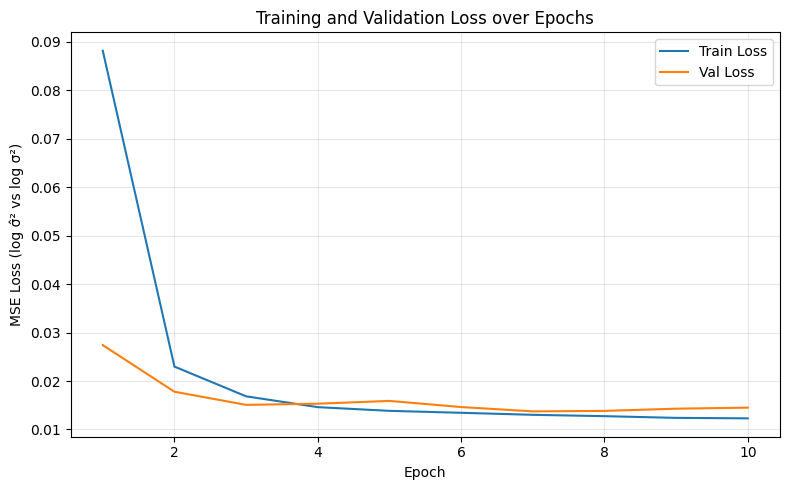


STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VAL + TEST)

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 4.7129e-02
  Val MAE: 9.1702e-02
  Val R² : 0.9922

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 1.5340e-02
  Mean |α_hat - α|      : 3.5379e-02
  Mean |β_hat - β|      : 3.6766e-02
  Mean rel error ω      : 32.52%
  Mean rel error α      : 56.46%
  Mean rel error β      : 4.75%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 1.5340e-02
  Mean |ω̂_arch - ω|   : 1.7399e-02
  Mean |α̂_NN   - α|   : 3.5379e-02
  Mean |α̂_arch - α|   : 1.9675e-02
  Mean |β̂_NN   - β|   : 3.6766e-02
  Mean |β̂_arch - β|   : 4.1957e-02

  Persistence C = α+β :
    Mean true C        : 0.9135
    Mean NN   Ĉ       : 0.9289
    Mean arch Ĉ       : 0.9058
    MAE C NN           : 3.1883e-02
    MAE C arch         : 2.9460e-02
Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_arch_param_errors

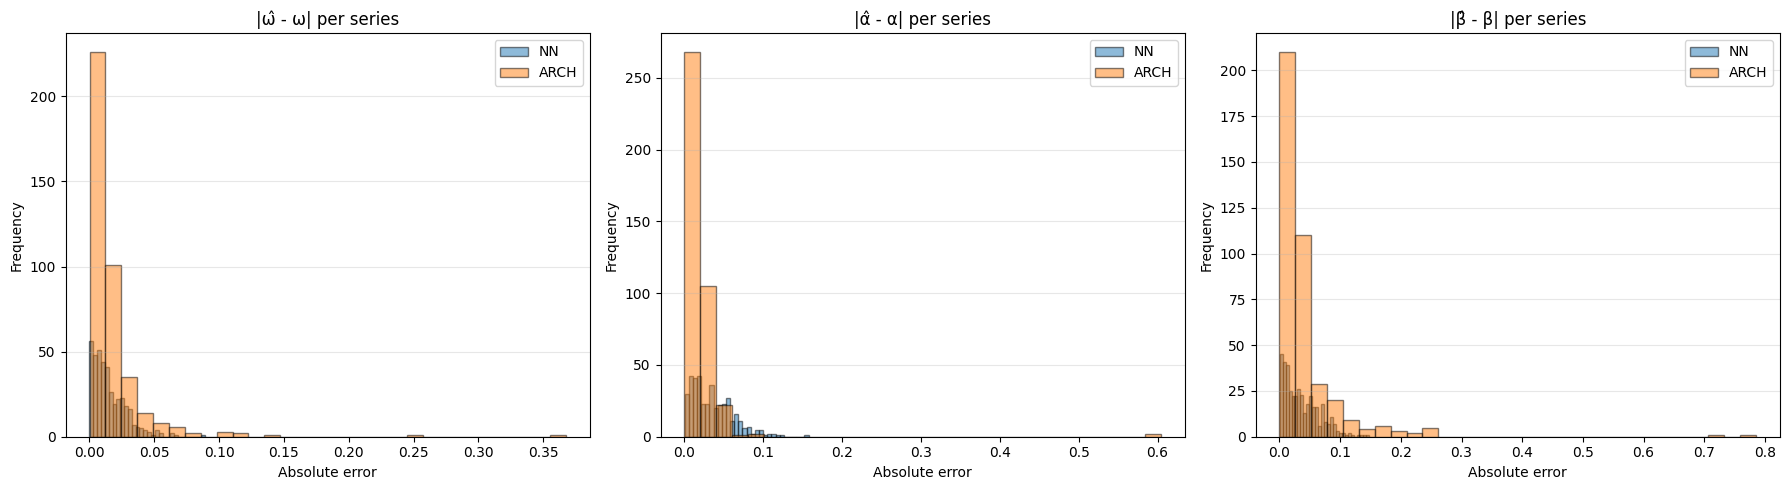

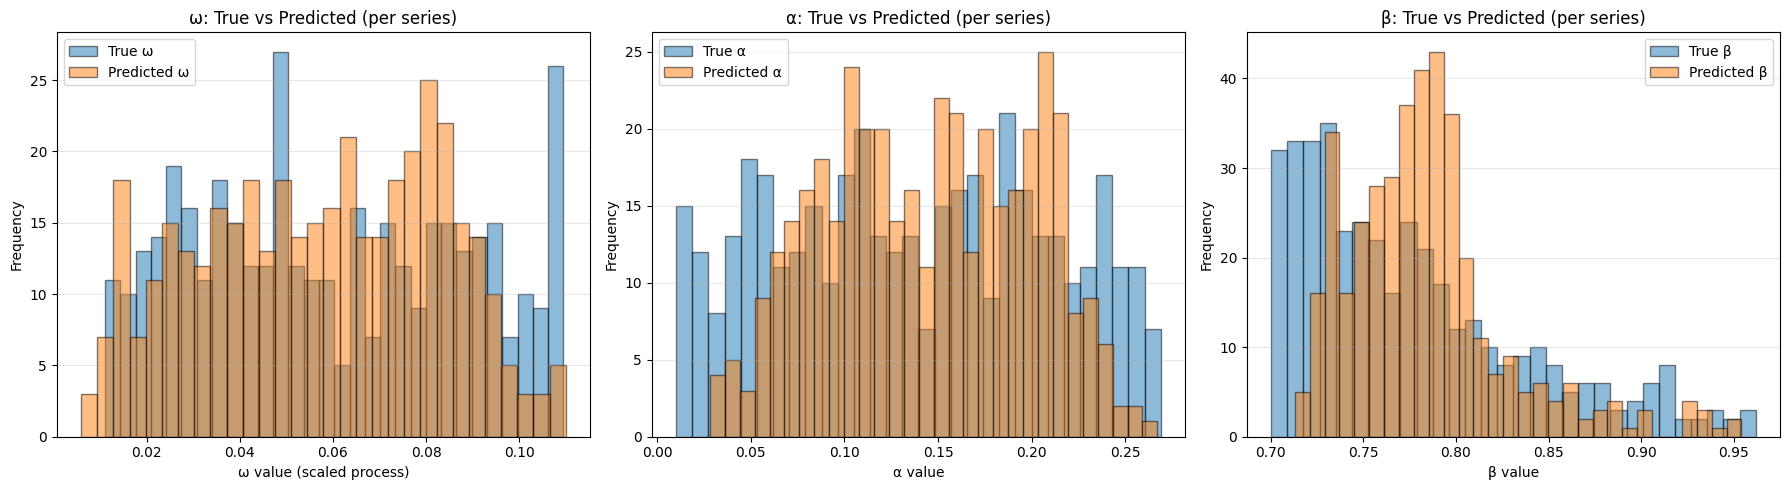

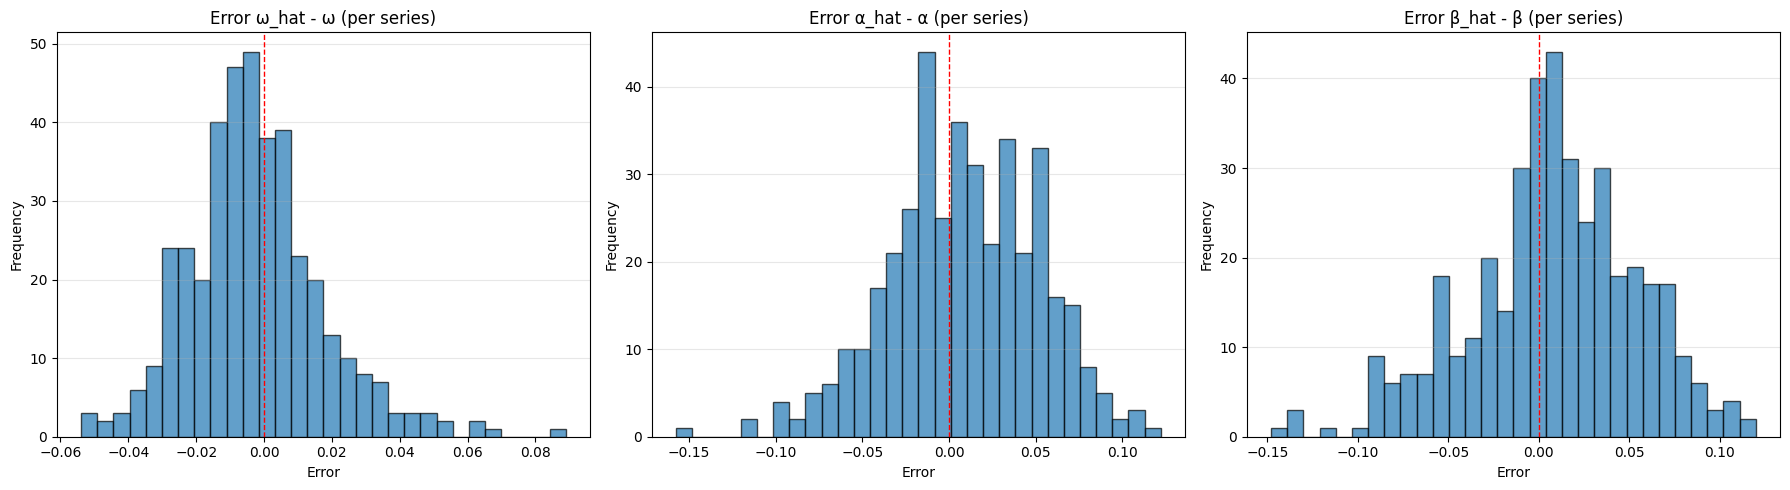

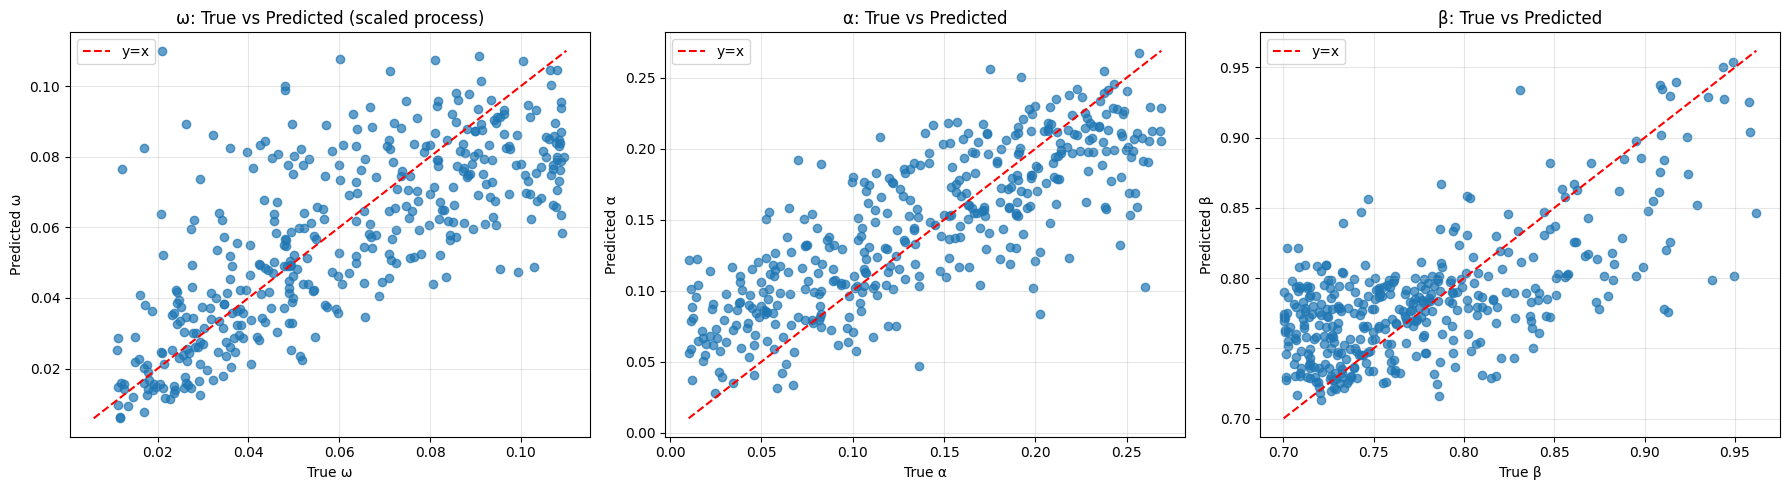

Mean true α+β : 0.9135258934037163
Mean pred α+β : 0.9288523569889366
Min pred α+β  : 0.8345703929662704
Max pred α+β  : 0.9892415329813957

Multi-series metrics summary (VALIDATION, scaled σ²):
  val_mse: 0.047129
  val_mae: 0.091702
  val_r2: 0.992210
  omega_abs_err_mean: 0.015340
  alpha_abs_err_mean: 0.035379
  beta_abs_err_mean: 0.036766

Key OOS metric (VAL): R² on σ²_t+1 (validation, scaled) = 0.9922

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 1.2413e-02
  Val MAE: 4.1832e-02
  Val R² : 0.9841

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 2.8393e-02
  Mean |α_hat - α|      : 3.7252e-02
  Mean |β_hat - β|      : 1.2461e-01
  Mean rel error ω      : 47.27%
  Mean rel error α      : 66.98%
  Mean rel error β      : 19.37%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 2.8393e-02
  Mean |ω̂_arch - ω|   : 2.1240e-02
  Mean |α̂_NN   - α|   : 3.7252e-02
  Mean |α̂_arch - α|   :

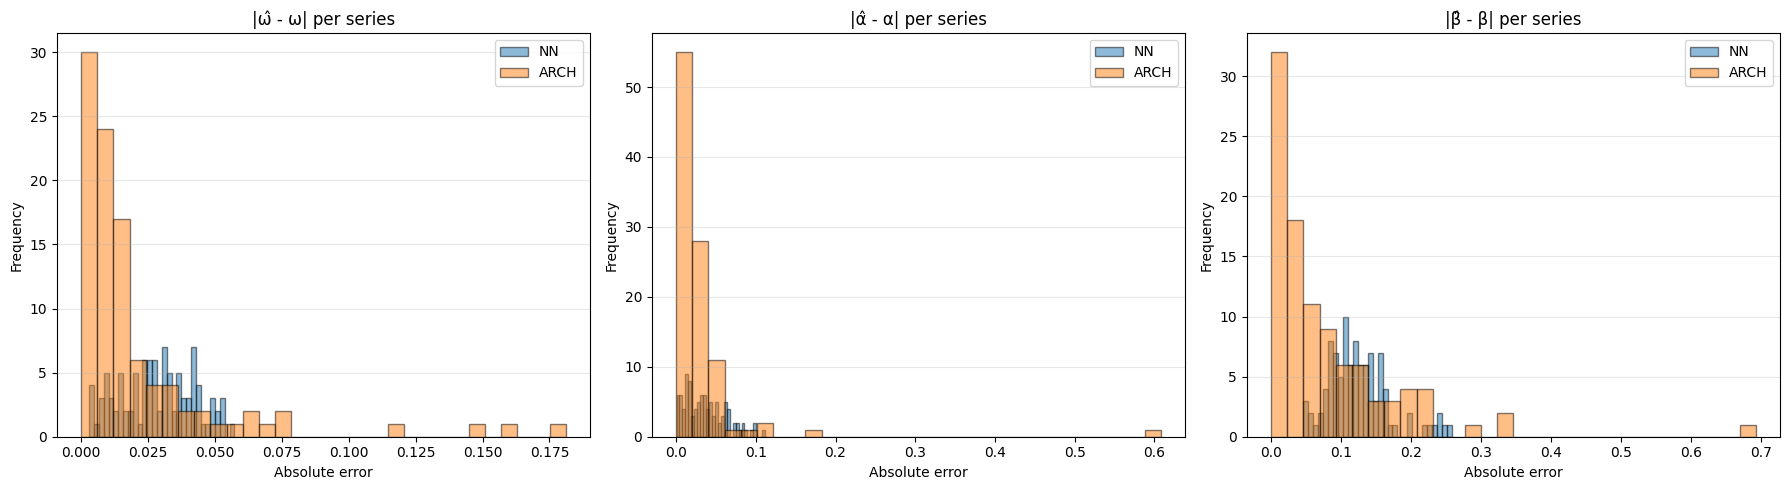

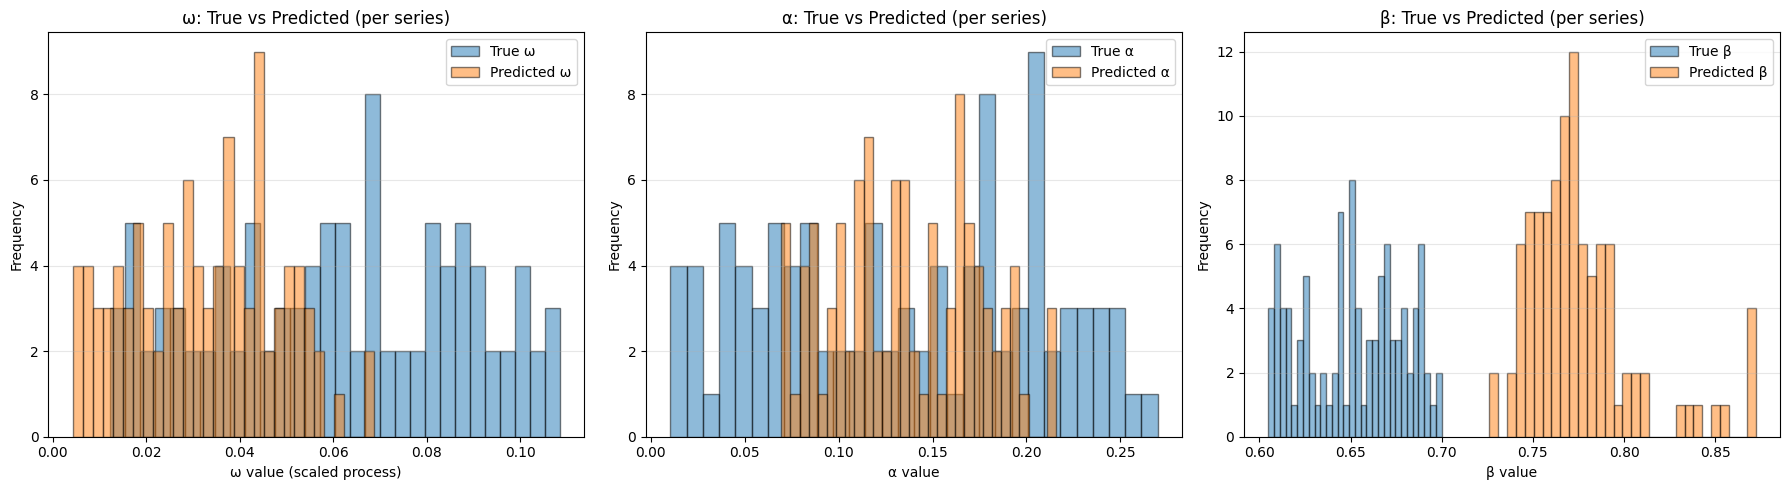

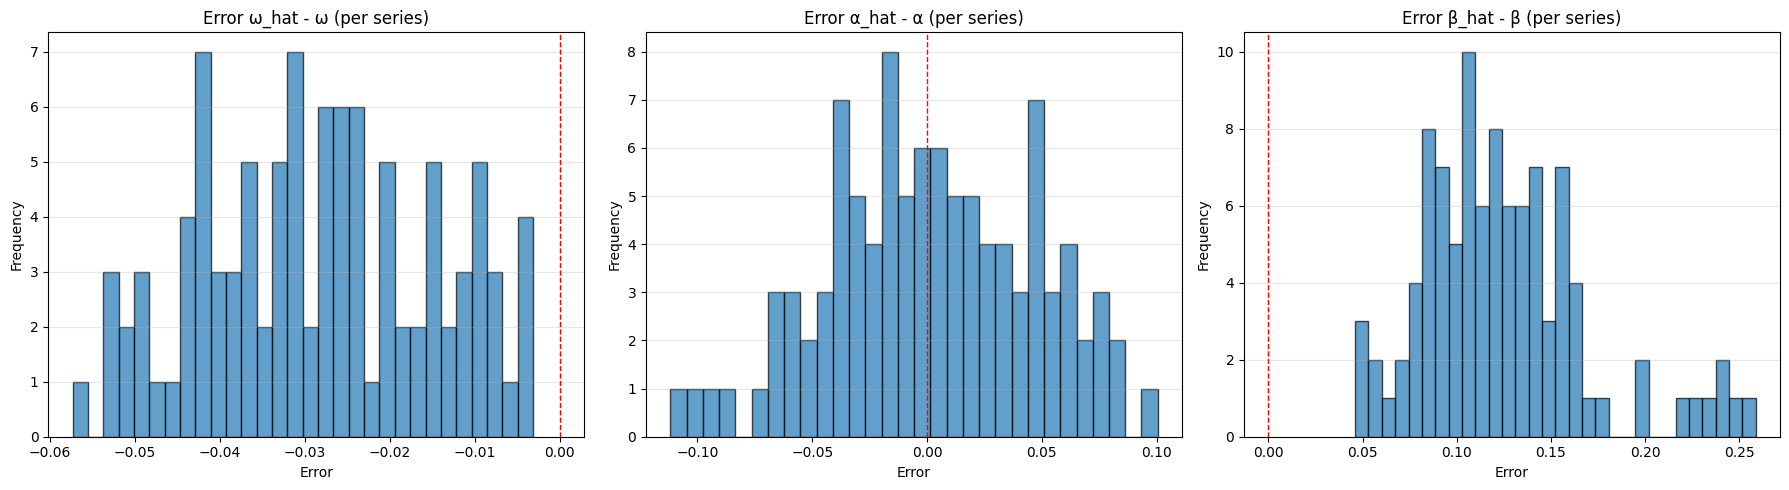

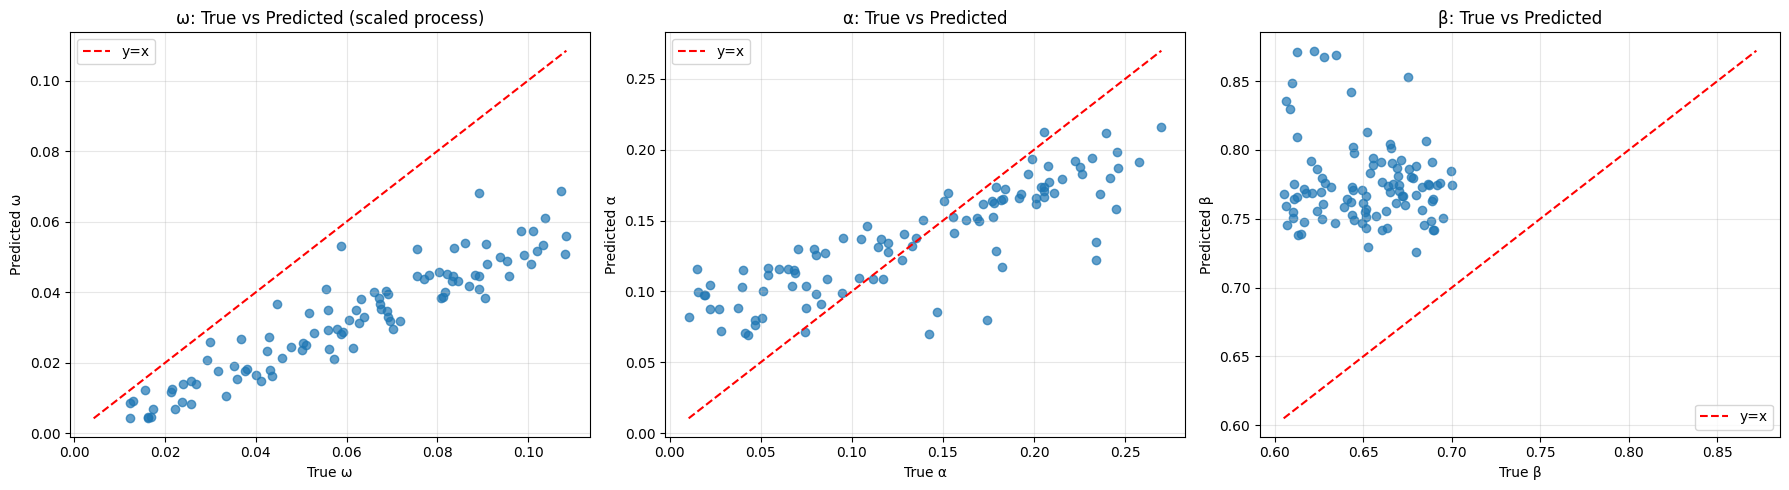

Mean true α+β : 0.785897083269641
Mean pred α+β : 0.9120653772354126
Min pred α+β  : 0.8681421801447868
Max pred α+β  : 0.9576207995414734

Multi-series metrics summary (TEST, scaled σ²):
  val_mse: 0.012413
  val_mae: 0.041832
  val_r2: 0.984127
  omega_abs_err_mean: 0.028393
  alpha_abs_err_mean: 0.037252
  beta_abs_err_mean: 0.124615

Key OOS metric (TEST): R² on σ²_t+1 (test, scaled) = 0.9841

STEP 6bis: FORECAST COMPARISON NN–GARCH vs GARCH(1,1)

[VALIDATION set — σ²_{t+1}, standardised process]
  NN–GARCH   MSE = 4.7129e-02, MAE = 9.1702e-02, R² = 0.9922
  GARCH(1,1) MSE = 2.3077e-02, MAE = 4.6584e-02, R² = 0.9956
  GARCH(1,1) MSE on σ_(t+1) (VAL, std): 1.4817e-03

[TEST set — σ²_{t+1}, standardised process]
  NN–GARCH   MSE = 1.2413e-02, MAE = 4.1832e-02, R² = 0.9841
  GARCH(1,1) MSE = 2.2202e-02, MAE = 4.9984e-02, R² = 0.9978
  GARCH(1,1) MSE on σ_(t+1) (TEST, std): 1.5575e-03
Saved NN vs ARCH forecast comparison to 'sigma2_forecast_nn_vs_arch_series0.png'


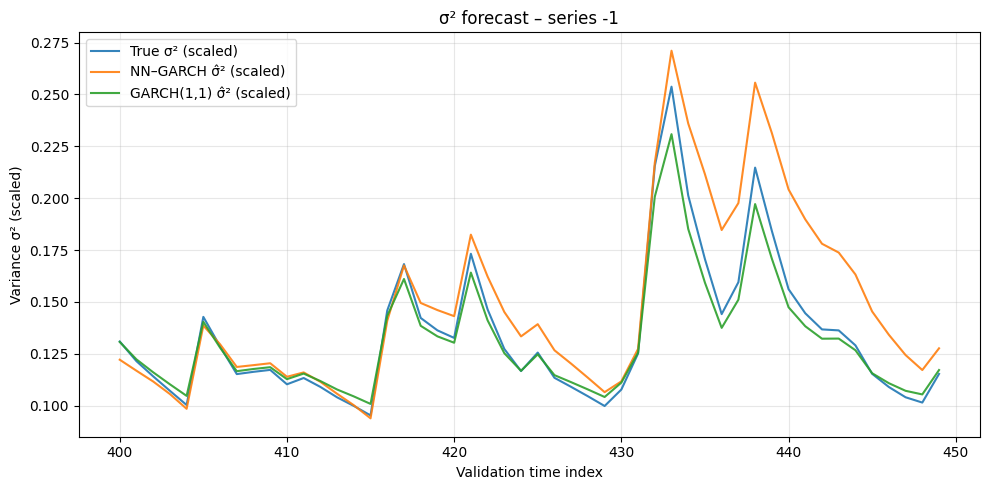


STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)

EXPERIMENT COMPLETED SUCCESSFULLY!

Key Achievements:
  ✓ NN approximates (scaled) GARCH parameters across many series
  ✓ Dynamic volatility layer captures time-varying variance on standardised returns
  ✓ Comparison NN–GARCH vs classical GARCH(1,1) on VALIDATION and TEST horizons

Generated Files:
  - training_curves.png
  - garch_multi_param_distributions.png
  - garch_multi_param_errors.png
  - garch_multi_param_scatter.png
  - garch_nn_vs_arch_param_errors.png
  - sigma2_forecast_nn_vs_arch_series0.png
  - alpha_train.png / alpha_val.png / alpha_test.png
  - beta_train.png / beta_val.png / beta_test.png
  - omega_train.png / omega_val.png / omega_test.png
  - best_garch_model_interpolation.pt (saved model weights)


In [54]:
# ============================================================================
# 10. MAIN EXAMPLE WITH FULL WORKFLOW
# ============================================================================

def main():
    """
    Complete workflow: Generate MULTI-SERIES GARCH data, train hybrid NN-GARCH model,
    and perform comprehensive multi-series evaluation.
    """
    print("=" * 80)
    print("HYBRID GARCH(1,1) + NEURAL NETWORK MODEL")
    print("Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)")
    print("Standardised returns + log-variance training")
    print("=" * 80)
    print()

    # ========== Configuration ==========
    N_SERIES   = 500
    N_SAMPLES  = 3000
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15   # reste pour test
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    # Time splits (en proportion de la longueur temporelle)
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    # ---------------------------------------------------------
    # TRUE PARAMETER SAMPLING — REAL EXTRAPOLATION
    # ---------------------------------------------------------
    N_TRAIN_SERIES = int(0.8 * N_SERIES)  # séries in-range (train/val)
    N_TEST_SERIES  = N_SERIES - N_TRAIN_SERIES  # séries extrapolation

    # TRAIN / VAL (IN-RANGE) : maintenant régime très persistant (α+β ≈ 0.9+)
    OMEGAS_TRAIN = np.random.uniform(0.01, 0.1, size=N_TRAIN_SERIES)
    ALPHAS_TRAIN = np.random.uniform(0.01, 0.27, size=N_TRAIN_SERIES)
    BETAS_TRAIN  = np.random.uniform(0.7, 0.97, size=N_TRAIN_SERIES)

    mask_bad = (ALPHAS_TRAIN + BETAS_TRAIN) >= 0.99
    while np.any(mask_bad):
        BETAS_TRAIN[mask_bad] = np.random.uniform(0.7, 0.97, mask_bad.sum())
        mask_bad = (ALPHAS_TRAIN + BETAS_TRAIN) >= 0.99


    # TEST (EXTRAPOLATION) : maintenant régime moins persistant (α+β ≈ 0.7)
    OMEGAS_TEST = np.random.uniform(0.01, 0.1, size=N_TEST_SERIES)
    ALPHAS_TEST = np.random.uniform(0.01, 0.27, size=N_TEST_SERIES)
    BETAS_TEST  = np.random.uniform(0.6, 0.70, size=N_TEST_SERIES)

    mask_bad = (ALPHAS_TEST + BETAS_TEST) >= 0.99
    while np.any(mask_bad):
        BETAS_TEST[mask_bad] = np.random.uniform(0.6, 0.80, mask_bad.sum())
        mask_bad = (ALPHAS_TEST + BETAS_TEST) >= 0.99

    # CONCATÉNATION finale (ordre : d'abord séries in-range, puis séries extrapolation)
    TRUE_OMEGAS = np.concatenate([OMEGAS_TRAIN, OMEGAS_TEST])
    TRUE_ALPHAS = np.concatenate([ALPHAS_TRAIN, ALPHAS_TEST])
    TRUE_BETAS  = np.concatenate([BETAS_TRAIN,  BETAS_TEST])

    print(f"Sampling random GARCH parameters for {N_SERIES} series...")
    print("Example (first 5):")
    for j in range(5):
        print(
            f"Series {j}: "
            f"omega={TRUE_OMEGAS[j]:.4f}, "
            f"alpha={TRUE_ALPHAS[j]:.4f}, "
            f"beta={TRUE_BETAS[j]:.4f}, "
            f"alpha+beta={TRUE_ALPHAS[j] + TRUE_BETAS[j]:.4f}"
        )

    # Model configuration
    WINDOW_SIZE = 400
    HIDDEN_DIM  = 128

    # Training configuration
    BATCH_SIZE    = 2048
    N_EPOCHS      = 10
    LEARNING_RATE = 1e-3

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}\n")

    # ========== Step 1: Generate GARCH Data Series ==========
    all_returns_list   = []
    all_variances_list = []

    for j in range(N_SERIES):
        generator = GARCHGenerator(
            omega=float(TRUE_OMEGAS[j]),
            alpha=float(TRUE_ALPHAS[j]),
            beta=float(TRUE_BETAS[j]),
            n_samples=N_SAMPLES,
            seed=42 + j  # different seed per series
        )

        returns_j, variances_j = generator.generate_series()
        all_returns_list.append(returns_j)
        all_variances_list.append(variances_j)

    # Stack into tensors: shape [N_SERIES, N_SAMPLES]
    all_returns   = torch.stack(all_returns_list,   dim=0)  # ORIGINAL scale
    all_variances = torch.stack(all_variances_list, dim=0)  # ORIGINAL σ²

    print(f"\nGenerated {N_SERIES} GARCH series:")
    print(f"  all_returns shape:   {all_returns.shape}")
    print(f"  all_variances shape: {all_variances.shape}")

    # ========== Step 1bis: Global standardisation of returns + rescale σ² ==========
    mean_r = all_returns.mean()
    std_r  = all_returns.std()
    std_r_f = float(std_r)

    all_returns   = (all_returns - mean_r) / (std_r + 1e-8)
    all_variances = all_variances / ((std_r + 1e-8) ** 2)

    print(f"\nStandardised returns globally:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")
    print(f"  Scale factor used (std of original returns): {std_r_f:.4f}")

    # On the standardised process, the true parameters become:
    # ω' = ω / std^2, α' = α, β' = β
    TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (std_r_f ** 2)
    TRUE_ALPHAS_SCALED = TRUE_ALPHAS
    TRUE_BETAS_SCALED  = TRUE_BETAS

    # ======================================================================
    #  SPLIT SERIES BETWEEN IN-RANGE (train/val) AND EXTRAPOLATION (test)
    # ======================================================================
    # 80% séries pour training/validation (in-range)
    returns_inrange   = all_returns[:N_TRAIN_SERIES]
    variances_inrange = all_variances[:N_TRAIN_SERIES]

    # 20% séries pour extrapolation (test)
    returns_extrap    = all_returns[N_TRAIN_SERIES:]
    variances_extrap  = all_variances[N_TRAIN_SERIES:]

    # ======================================================================
    #  TIME SPLIT (ONLY FOR IN-RANGE SERIES)
    # ======================================================================
    train_returns_in   = returns_inrange[:, :train_len]
    train_variances_in = variances_inrange[:, :train_len]

    val_returns_in     = returns_inrange[:, train_len:train_len + val_len]
    val_variances_in   = variances_inrange[:, train_len:train_len + val_len]

    # ======================================================================
    #  EXTRAPOLATION SERIES: NO TRAIN/VAL SPLIT -> FULL SERIES USED AS TEST
    # ======================================================================
    test_returns_ex    = returns_extrap           # [N_TEST_SERIES, N_SAMPLES]
    test_variances_ex  = variances_extrap

    # ========== Step 2: Create Train/Val/Test datasets from ALL series ==========
    train_returns   = all_returns[:, :train_len]                       # [N_SERIES, train_len]
    train_variances = all_variances[:, :train_len]

    val_returns     = all_returns[:, train_len:train_len + val_len]    # [N_SERIES, val_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]

    test_returns    = all_returns[:, train_len + val_len:]             # [N_SERIES, test_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    # ========= 2b. Fit classical GARCH(1,1) with arch_model on TRAIN only =========
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()   # shape [train_len], standardised
        am = arch_model(
            r_train,
            vol='GARCH',
            p=1,
            q=1,
            mean='Zero',
            dist='normal',
            rescale=False,    # IMPORTANT: avoid internal rescale
        )
        res = am.fit(disp='off')

        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    C_true = TRUE_ALPHAS_SCALED + TRUE_BETAS_SCALED
    C_arch = garch_alpha_hat + garch_beta_hat

    print("True C = α+β (mean/min/max):",
          C_true.mean(), C_true.min(), C_true.max())
    print("ARCH Ĉ = α̂+β̂ (mean/min/max):",
          C_arch.mean(), C_arch.min(), C_arch.max())

    print("omega true (scaled) mean/min/max:",
          TRUE_OMEGAS_SCALED.mean(), TRUE_OMEGAS_SCALED.min(), TRUE_OMEGAS_SCALED.max())
    print("omega_hat ARCH mean/min/max:",
          garch_omega_hat.mean(), garch_omega_hat.min(), garch_omega_hat.max())

    # ---------- Projection des paramètres ARCH dans le même domaine que le générateur ----------
    C_min, C_max = C_true.min(), C_true.max()
    C_hat = garch_alpha_hat + garch_beta_hat

    C_clipped = np.clip(C_hat, C_min, C_max)
    scale = C_clipped / (C_hat + 1e-8)
    garch_alpha_hat *= scale
    garch_beta_hat  *= scale

    C_arch_proj = garch_alpha_hat + garch_beta_hat
    print("ARCH Ĉ after projection (mean/min/max):",
          C_arch_proj.mean(), C_arch_proj.min(), C_arch_proj.max())

    # ========= Step 2c: Build PyTorch datasets and loaders =========
    # IN-RANGE (train/val) + EXTRAPOLATION (test)
    train_dataset = MultiGARCHDataset(train_returns_in, train_variances_in, WINDOW_SIZE)
    val_dataset   = MultiGARCHDataset(val_returns_in,   val_variances_in,   WINDOW_SIZE)
    test_dataset  = MultiGARCHDataset(test_returns_ex,  test_variances_ex,  WINDOW_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches:   {len(val_loader)}")

    # ========== Step 3: Initialize Model ==========
    print("\n" + "=" * 80)
    print("STEP 3: INITIALIZING HYBRID MODEL")
    print("=" * 80)

    model = HybridGARCHModel(input_seq_len=WINDOW_SIZE, hidden_dim=HIDDEN_DIM)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model architecture:")
    print(f"  Parameter Network: Conv1d → MLP → (ω, α, β)")
    print(f"  Volatility Layer:  GARCH(1,1) recursion")
    print(f"  Total trainable parameters: {total_params:,}")

    print(f"\nModel structure:")
    print(model)

    # ========== Step 4: Train Model ==========
    print("\n" + "=" * 80)
    print("STEP 4: TRAINING HYBRID MODEL")
    print("=" * 80)
    print(f"Epochs: {N_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Optimizer: Adam with weight decay")
    print(f"Loss: MSE between predicted and true log-variance log(σ²)")
    print()

    history = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device,
        checkpoint_path="best_garch_model_interpolation.pt",
        load_best=True,
    )

    # ======= SAUVEGARDE DU MODELE PRE-ENTRAINE SUR DONNEES SYNTHETIQUES =======
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "window_size": WINDOW_SIZE,
        "hidden_dim": HIDDEN_DIM,
        "mean_r": float(mean_r),
        "std_r": float(std_r),
        "n_series": N_SERIES,
        "n_samples": N_SAMPLES,
    }

    torch.save(checkpoint, "hybrid_garch_pretrained_synth.pt")
    print("\nSaved pretrained synthetic model to 'hybrid_garch_pretrained_synth.pt'")

    # ========== Step 5: Global Loss Summary ==========
    print("\n" + "=" * 80)
    print("STEP 5: GLOBAL TRAINING SUMMARY")
    print("=" * 80)

    print("\nLoss Summary (log-variance MSE):")
    print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
    print(f"  Final train loss:   {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss:     {history['val_loss'][-1]:.6f}")
    print(f"  Loss reduction:     {(1 - history['train_loss'][-1] / history['train_loss'][0]) * 100:.2f}%")

    plot_training_curves(history, save_path="training_curves.png")

    # ========== Step 6: Multi-Series Visualizations (VALIDATION + TEST) ==========
    print("\n" + "=" * 80)
    print("STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VAL + TEST)")
    print("=" * 80)

    # Bloc 1 : metrics sur VALIDATION (in-range séries)
    metrics_val = create_visualizations_multi(
        model=model,
        val_dataset=val_dataset,         # MultiGARCHDataset (std scale, N_TRAIN_SERIES)
        true_omegas=TRUE_OMEGAS_SCALED[:N_TRAIN_SERIES],
        true_alphas=TRUE_ALPHAS_SCALED[:N_TRAIN_SERIES],
        true_betas=TRUE_BETAS_SCALED[:N_TRAIN_SERIES],
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat[:N_TRAIN_SERIES],
        garch_alphas=garch_alpha_hat[:N_TRAIN_SERIES],
        garch_betas=garch_beta_hat[:N_TRAIN_SERIES],
    )

    print("\nMulti-series metrics summary (VALIDATION, scaled σ²):")
    for k, v in metrics_val.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric (VAL): R² on σ²_t+1 (validation, scaled) = {metrics_val['val_r2']:.4f}")

    # Bloc 2 : metrics sur TEST (séries extrapolation)
    metrics_test = create_visualizations_multi(
        model=model,
        val_dataset=test_dataset,        # MultiGARCHDataset (std scale, N_TEST_SERIES)
        true_omegas=TRUE_OMEGAS_SCALED[N_TRAIN_SERIES:],
        true_alphas=TRUE_ALPHAS_SCALED[N_TRAIN_SERIES:],
        true_betas=TRUE_BETAS_SCALED[N_TRAIN_SERIES:],
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat[N_TRAIN_SERIES:],
        garch_alphas=garch_alpha_hat[N_TRAIN_SERIES:],
        garch_betas=garch_beta_hat[N_TRAIN_SERIES:],
    )

    print("\nMulti-series metrics summary (TEST, scaled σ²):")
    for k, v in metrics_test.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric (TEST): R² on σ²_t+1 (test, scaled) = {metrics_test['val_r2']:.4f}")

    # ========== Step 6bis: Forecast comparison NN–GARCH vs classical GARCH(1,1) ==========
    print("\n" + "=" * 80)
    print("STEP 6bis: FORECAST COMPARISON NN–GARCH vs GARCH(1,1)")
    print("=" * 80)

    all_returns_np   = all_returns.numpy()      # [N_SERIES, N_SAMPLES], std
    all_variances_np = all_variances.numpy()    # [N_SERIES, N_SAMPLES], σ² std

    # σ̂²_t GARCH(1,1) pour toutes les séries / tous les t
    arch_sigma2_hat = np.zeros_like(all_returns_np)
    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    # ---------- Bloc VALIDATION ----------
    arch_val_sigma2 = arch_sigma2_hat[:, train_len:train_len + val_len]
    true_val_sigma2 = all_variances_np[:, train_len:train_len + val_len]

    targets_val = []
    arch_val    = []
    for j in range(N_SERIES):
        for t in range(val_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_val.append(true_val_sigma2[j, idx])   # vraie σ²_{t+1} (std)
            arch_val.append(arch_val_sigma2[j, idx])      # σ̂²_{t+1} GARCH (std)

    targets_val = np.array(targets_val)
    arch_val    = np.array(arch_val)

    mse_arch_val = np.mean((arch_val - targets_val)**2)
    mae_arch_val = np.mean(np.abs(arch_val - targets_val))
    r2_arch_val  = np.corrcoef(targets_val, arch_val)[0, 1]**2

    print("\n[VALIDATION set — σ²_{t+1}, standardised process]")
    print(f"  NN–GARCH   MSE = {metrics_val['val_mse']:.4e}, "
          f"MAE = {metrics_val['val_mae']:.4e}, "
          f"R² = {metrics_val['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch_val:.4e}, "
          f"MAE = {mae_arch_val:.4e}, "
          f"R² = {r2_arch_val:.4f}")

    sigma_true_val = np.sqrt(np.clip(targets_val, 1e-12, None))
    sigma_arch_val = np.sqrt(np.clip(arch_val,    1e-12, None))
    mse_sigma_arch_val = np.mean((sigma_arch_val - sigma_true_val)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (VAL, std): {mse_sigma_arch_val:.4e}")

    # ---------- Bloc TEST ----------
    arch_test_sigma2 = arch_sigma2_hat[:, train_len + val_len:]
    true_test_sigma2 = all_variances_np[:, train_len + val_len:]

    targets_test = []
    arch_test    = []
    for j in range(N_SERIES):
        for t in range(test_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_test.append(true_test_sigma2[j, idx])   # vraie σ²_{t+1} (std)
            arch_test.append(arch_test_sigma2[j, idx])      # σ̂²_{t+1} GARCH (std)

    targets_test = np.array(targets_test)
    arch_test    = np.array(arch_test)

    mse_arch_test = np.mean((arch_test - targets_test)**2)
    mae_arch_test = np.mean(np.abs(arch_test - targets_test))
    r2_arch_test  = np.corrcoef(targets_test, arch_test)[0, 1]**2

    print("\n[TEST set — σ²_{t+1}, standardised process]")
    print(f"  NN–GARCH   MSE = {metrics_test['val_mse']:.4e}, "
          f"MAE = {metrics_test['val_mae']:.4e}, "
          f"R² = {metrics_test['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch_test:.4e}, "
          f"MAE = {mae_arch_test:.4e}, "
          f"R² = {r2_arch_test:.4f}")

    sigma_true_test = np.sqrt(np.clip(targets_test, 1e-12, None))
    sigma_arch_test = np.sqrt(np.clip(arch_test,    1e-12, None))
    mse_sigma_arch_test = np.mean((sigma_arch_test - sigma_true_test)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (TEST, std): {mse_sigma_arch_test:.4e}")

    # ========== Step 6ter: Visual comparison of σ² forecasts on one series ==========
    plot_forecast_comparison_nn_vs_arch(
        model=model,
        val_returns=val_returns,             # torch.Tensor [N_SERIES, val_len] std
        true_val_sigma2=true_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        arch_val_sigma2=arch_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        window_size=WINDOW_SIZE,
        device=device,
        series_idx=-1,
        save_path="sigma2_forecast_nn_vs_arch_series0.png",
    )

    # ========== Step 7: α_true vs α_pred plots for TRAIN / VAL / TEST ==========
    print("\n" + "=" * 80)
    print("STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)")
    print("=" * 80)

    omega_hat_train, alpha_hat_train, beta_hat_train = collect_parameters_per_series(
        model, train_dataset, device, batch_size=BATCH_SIZE
    )
    omega_hat_val, alpha_hat_val, beta_hat_val = collect_parameters_per_series(
        model, val_dataset, device, batch_size=BATCH_SIZE
    )
    omega_hat_test, alpha_hat_test, beta_hat_test = collect_parameters_per_series(
        model, test_dataset, device, batch_size=BATCH_SIZE
    )

    # TRUE parameters subsets
    TRUE_ALPHAS_TRAIN = TRUE_ALPHAS_SCALED[:N_TRAIN_SERIES]
    TRUE_ALPHAS_TEST  = TRUE_ALPHAS_SCALED[N_TRAIN_SERIES:]
    TRUE_OMEGAS_TRAIN = TRUE_OMEGAS_SCALED[:N_TRAIN_SERIES]
    TRUE_BETAS_TRAIN  = TRUE_BETAS_SCALED[:N_TRAIN_SERIES]

    TRUE_OMEGAS_TEST = TRUE_OMEGAS_SCALED[N_TRAIN_SERIES:]
    TRUE_BETAS_TEST  = TRUE_BETAS_SCALED[N_TRAIN_SERIES:]

    # Plots α
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TRAIN, alpha_hat_train,
        "Train (in-range α)", "alpha_train.png", param_name="alpha"
    )
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TRAIN, alpha_hat_val,
        "Validation (in-range α)", "alpha_val.png", param_name="alpha"
    )
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TEST, alpha_hat_test,
        "Test (extrapolation α)", "alpha_test.png", param_name="alpha"
    )

    # Plots β
    plot_param_true_vs_pred(
        TRUE_BETAS_TRAIN, beta_hat_train,
        "Train (in-range β)", "beta_train.png", param_name="beta"
    )
    plot_param_true_vs_pred(
        TRUE_BETAS_TRAIN, beta_hat_val,
        "Validation (in-range β)", "beta_val.png", param_name="beta"
    )
    plot_param_true_vs_pred(
        TRUE_BETAS_TEST, beta_hat_test,
        "Test (extrapolation β)", "beta_test.png", param_name="beta"
    )

    # Plots ω
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TRAIN, omega_hat_train,
        "Train (in-range ω)", "omega_train.png", param_name="omega"
    )
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TRAIN, omega_hat_val,
        "Validation (in-range ω)", "omega_val.png", param_name="omega"
    )
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TEST, omega_hat_test,
        "Test (extrapolation ω)", "omega_test.png", param_name="omega"
    )

    # ========== Summary ==========
    print("\n" + "=" * 80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print("\nKey Achievements:")
    print("  ✓ NN approximates (scaled) GARCH parameters across many series")
    print("  ✓ Dynamic volatility layer captures time-varying variance on standardised returns")
    print("  ✓ Comparison NN–GARCH vs classical GARCH(1,1) on VALIDATION and TEST horizons")
    print("\nGenerated Files:")
    print("  - training_curves.png")
    print("  - garch_multi_param_distributions.png")
    print("  - garch_multi_param_errors.png")
    print("  - garch_multi_param_scatter.png")
    print("  - garch_nn_vs_arch_param_errors.png")
    print("  - sigma2_forecast_nn_vs_arch_series0.png")
    print("  - alpha_train.png / alpha_val.png / alpha_test.png")
    print("  - beta_train.png / beta_val.png / beta_test.png")
    print("  - omega_train.png / omega_val.png / omega_test.png")
    print("  - best_garch_model_interpolation.pt (saved model weights)")
    print("=" * 80)


main()


HYBRID GARCH(1,1) + NEURAL NETWORK MODEL
Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)
Standardised returns + log-variance training

Sampling random GARCH parameters for 2000 series...
Example (first 5):
Series 0: omega=0.0166, alpha=0.4467, beta=0.4973, alpha+beta=0.9440
Series 1: omega=0.0944, alpha=0.4051, beta=0.4644, alpha+beta=0.8695
Series 2: omega=0.0691, alpha=0.4954, beta=0.3200, alpha+beta=0.8154
Series 3: omega=0.0580, alpha=0.4704, beta=0.1221, alpha+beta=0.5925
Series 4: omega=0.0726, alpha=0.3742, beta=0.4098, alpha+beta=0.7841

Using device: cuda


Generated 2000 GARCH series:
  all_returns shape:   torch.Size([2000, 2200])
  all_variances shape: torch.Size([2000, 2200])

Standardised returns globally:
  mean ≈ 0.0000, std ≈ 1.0000
  Scale factor used (std of original returns): 0.6785

Train time length: 1540
Val time length:   330
Test time length:  330
True C = α+β (mean/min/max): 0.7588343133176159 0.374362393089531 0.9899819820951417
ARCH Ĉ = α̂+β

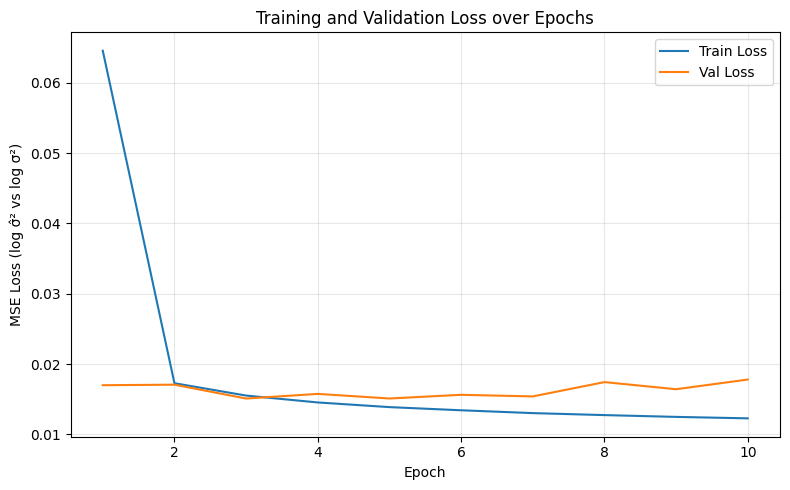


STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VAL + TEST)

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 2.7303e-02
  Val MAE: 5.4421e-02
  Val R² : 0.9960

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 2.3375e-02
  Mean |α_hat - α|      : 4.5860e-02
  Mean |β_hat - β|      : 8.2020e-02
  Mean rel error ω      : 22.95%
  Mean rel error α      : 11.85%
  Mean rel error β      : 48.45%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 2.3375e-02
  Mean |ω̂_arch - ω|   : 1.3668e-02
  Mean |α̂_NN   - α|   : 4.5860e-02
  Mean |α̂_arch - α|   : 3.5783e-02
  Mean |β̂_NN   - β|   : 8.2020e-02
  Mean |β̂_arch - β|   : 4.5696e-02

  Persistence C = α+β :
    Mean true C        : 0.7177
    Mean NN   Ĉ       : 0.7440
    Mean arch Ĉ       : 0.7152
    MAE C NN           : 7.4812e-02
    MAE C arch         : 3.9987e-02
Saved NN vs ARCH parameter error comparison to 'garch_nn_vs_arch_param_error

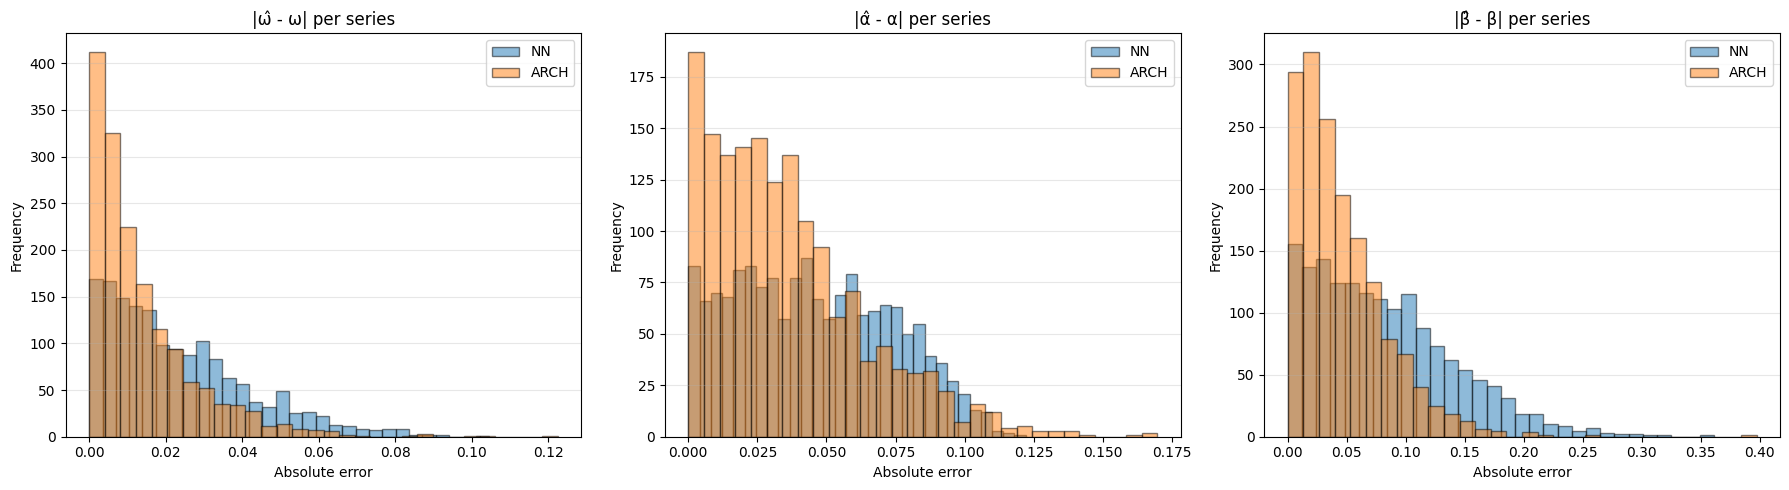

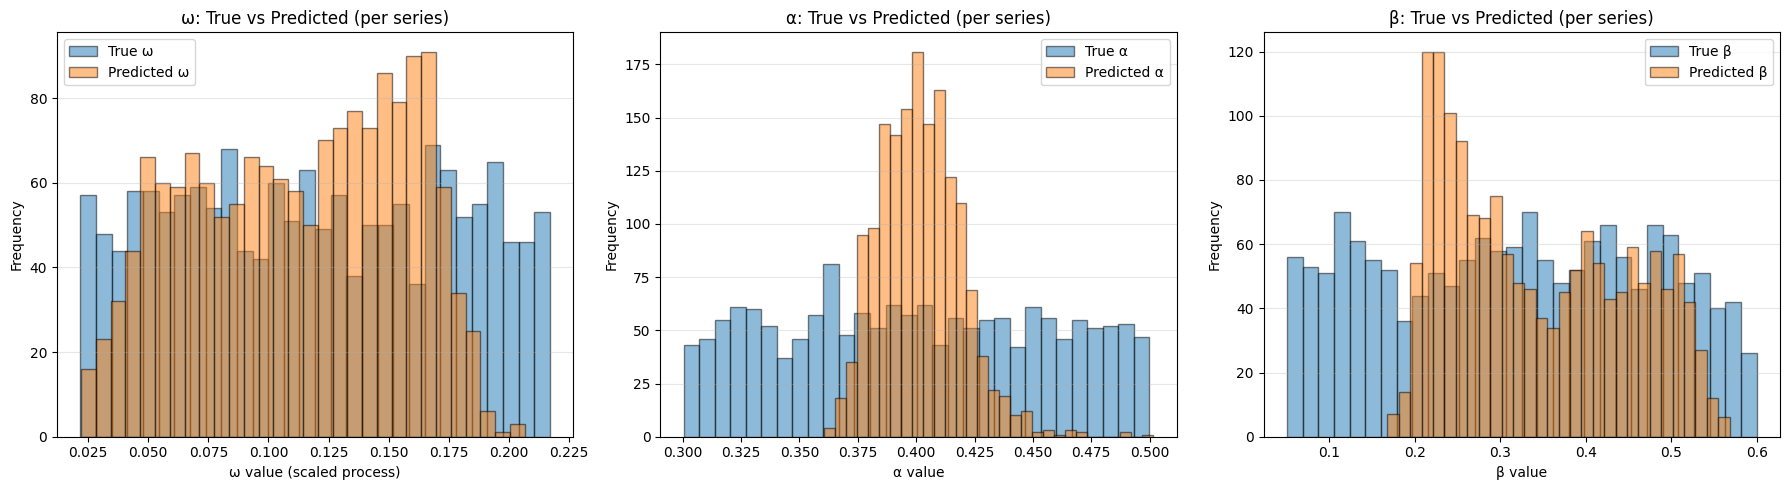

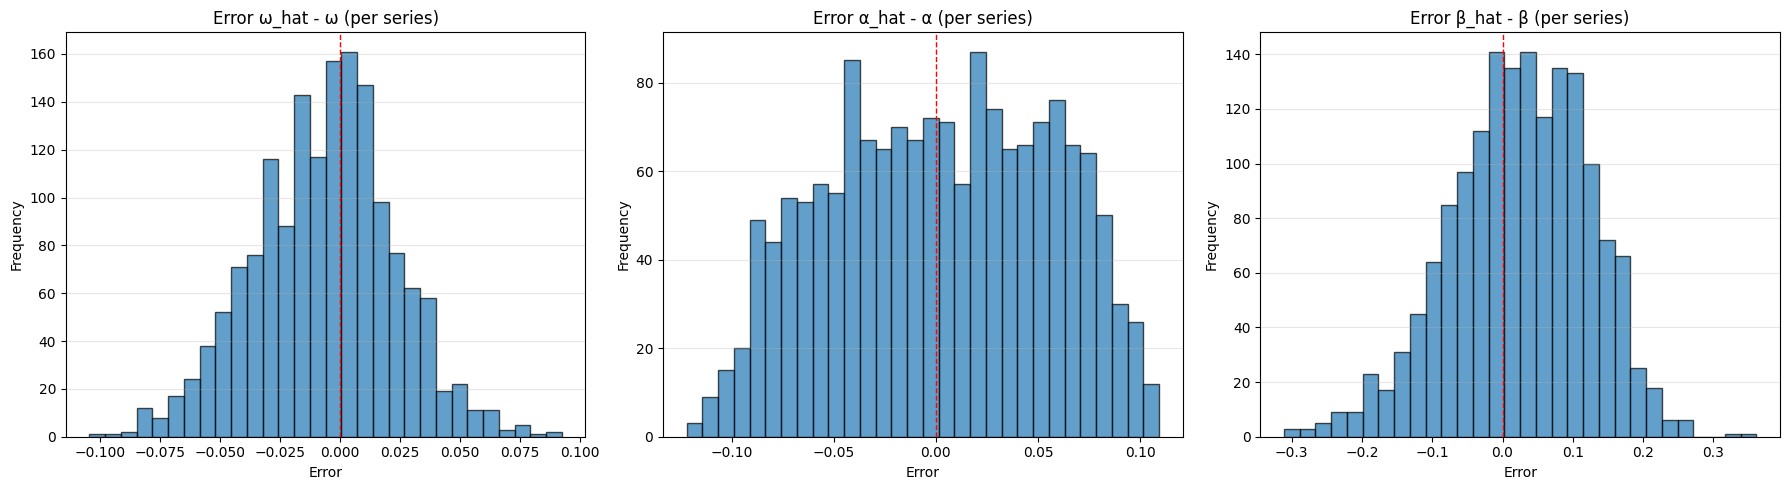

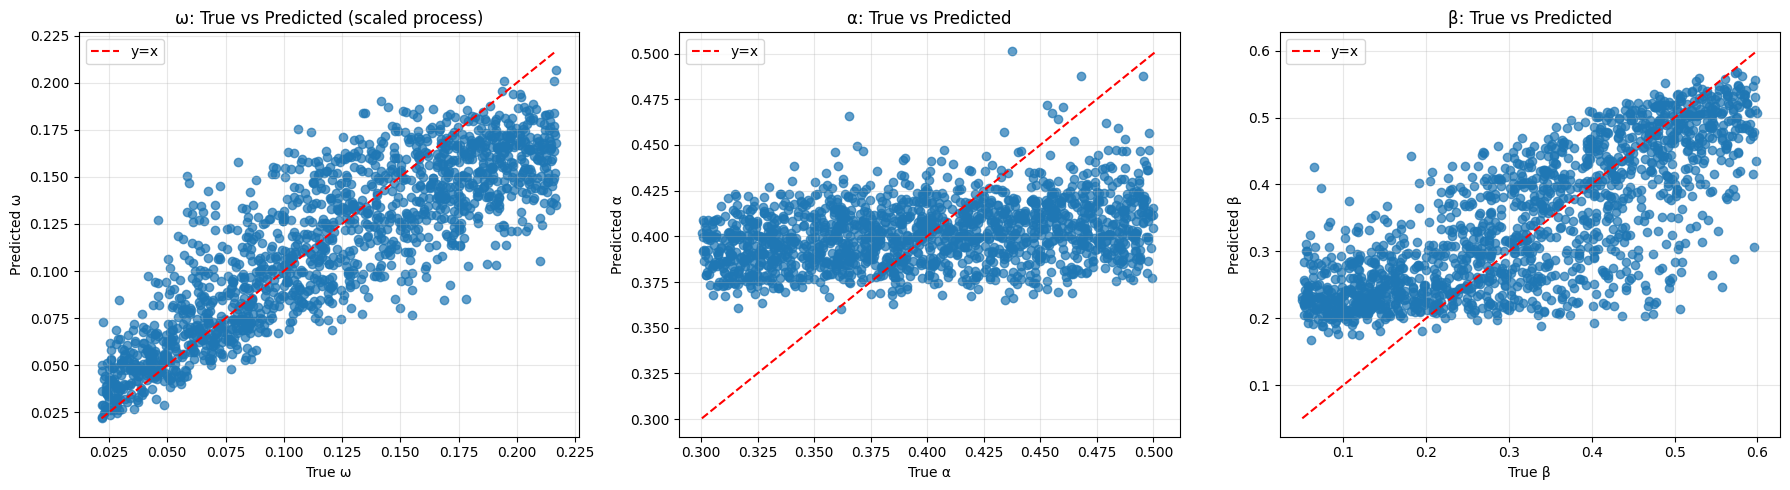

Mean true α+β : 0.717742192072654
Mean pred α+β : 0.7439656701032072
Min pred α+β  : 0.5283470302820206
Max pred α+β  : 0.9894195795059204

Multi-series metrics summary (VALIDATION, scaled σ²):
  val_mse: 0.027303
  val_mae: 0.054421
  val_r2: 0.995988
  omega_abs_err_mean: 0.023375
  alpha_abs_err_mean: 0.045860
  beta_abs_err_mean: 0.082020

Key OOS metric (VAL): R² on σ²_t+1 (validation, scaled) = 0.9960

[Multi-Series] Variance prediction quality on validation set (scaled σ²):
  Val MSE: 3.9117e+00
  Val MAE: 3.6931e-01
  Val R² : 0.9467

[Multi-Series] Parameter error summary (NN, validation):
  Mean |ω_hat - ω|      : 4.1238e-02
  Mean |α_hat - α|      : 1.4862e-01
  Mean |β_hat - β|      : 1.7166e-01
  Mean rel error ω      : 62.12%
  Mean rel error α      : 60.17%
  Mean rel error β      : 25.61%

[Comparison: NN vs arch_model vs true parameters]
  Mean |ω̂_NN   - ω|   : 4.1238e-02
  Mean |ω̂_arch - ω|   : 1.9734e-02
  Mean |α̂_NN   - α|   : 1.4862e-01
  Mean |α̂_arch - α|   : 

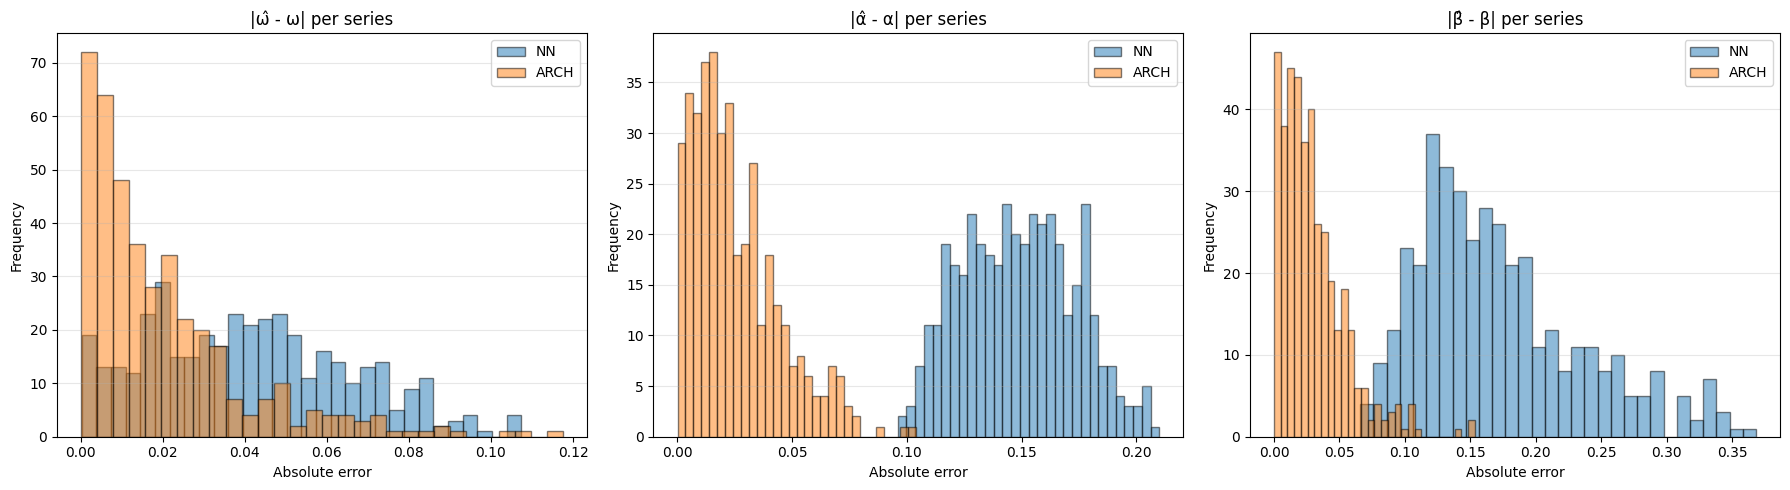

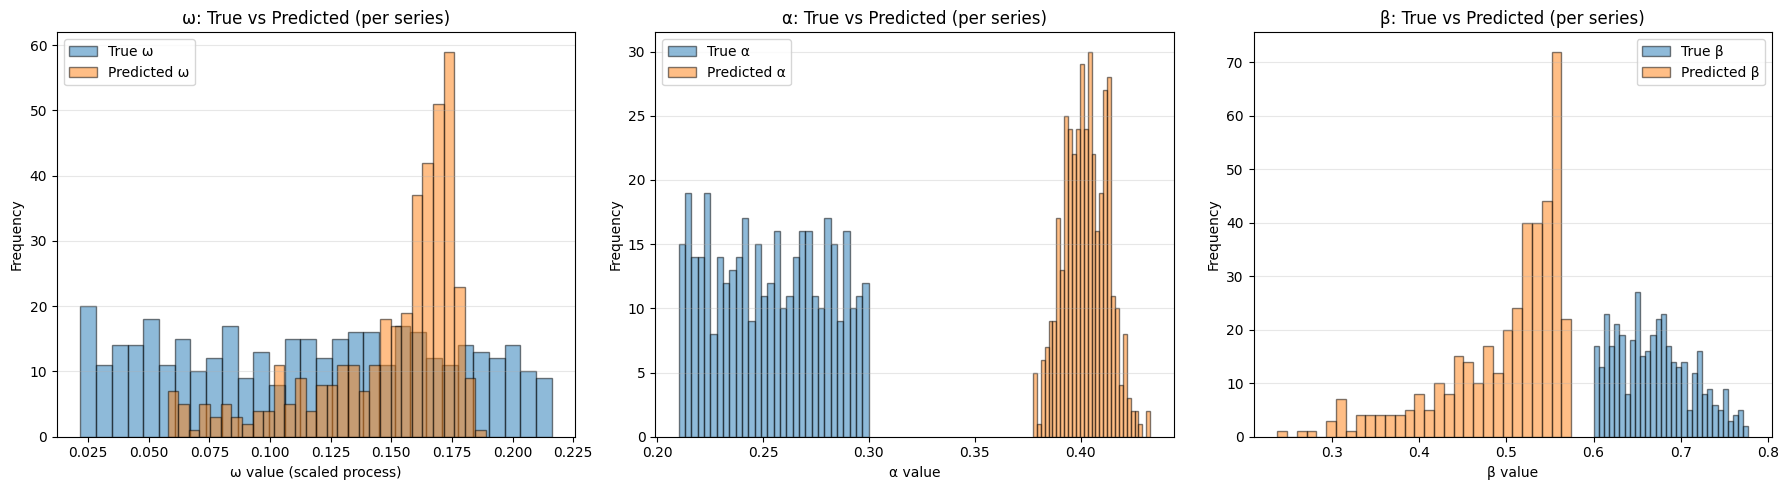

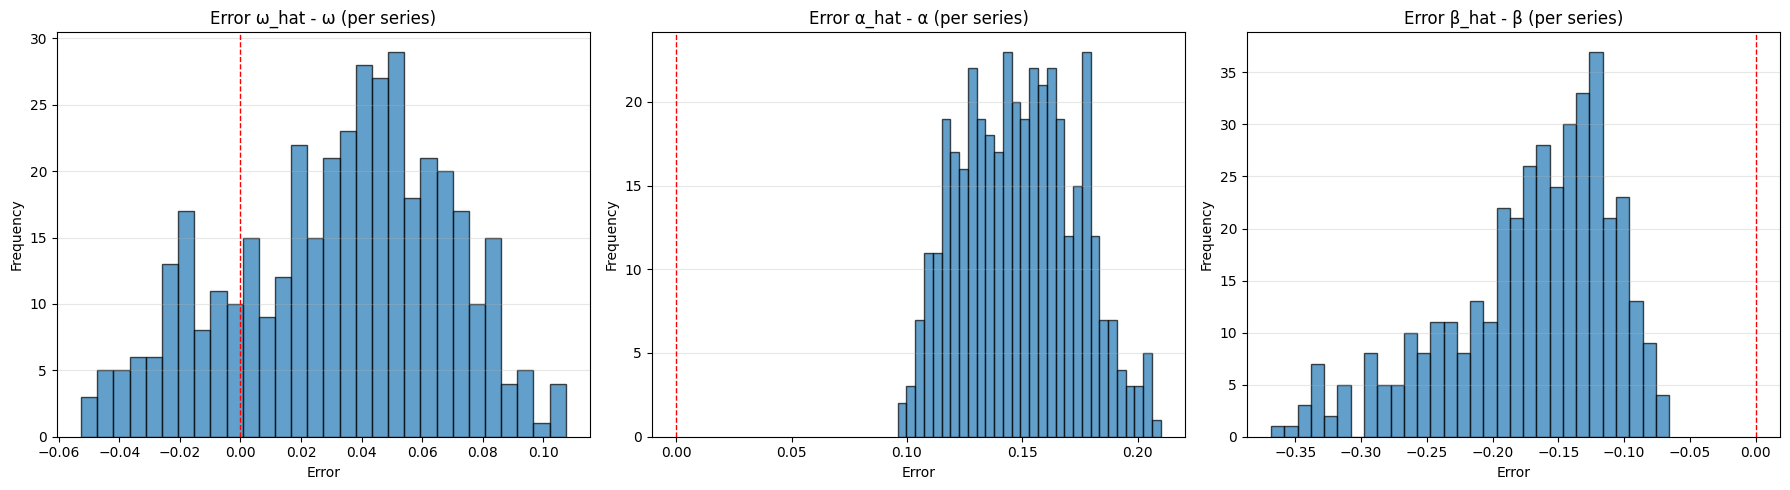

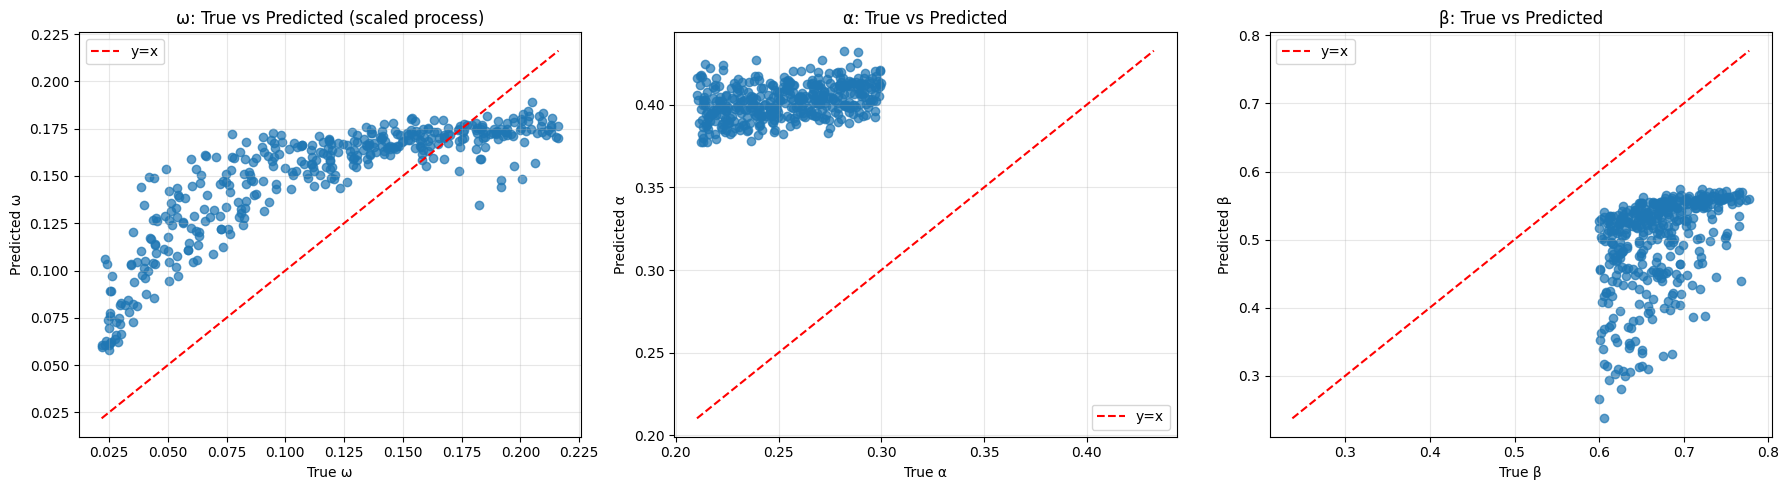

Mean true α+β : 0.9232027982974631
Mean pred α+β : 0.9001655612140894
Min pred α+β  : 0.6222574710845947
Max pred α+β  : 0.9875107705593109

Multi-series metrics summary (TEST, scaled σ²):
  val_mse: 3.911672
  val_mae: 0.369314
  val_r2: 0.946686
  omega_abs_err_mean: 0.041238
  alpha_abs_err_mean: 0.148618
  beta_abs_err_mean: 0.171655

Key OOS metric (TEST): R² on σ²_t+1 (test, scaled) = 0.9467

STEP 6bis: FORECAST COMPARISON NN–GARCH vs GARCH(1,1)

[VALIDATION set — σ²_{t+1}, standardised process]
  NN–GARCH   MSE = 2.7303e-02, MAE = 5.4421e-02, R² = 0.9960
  GARCH(1,1) MSE = 1.3137e-01, MAE = 5.3525e-02, R² = 0.9966
  GARCH(1,1) MSE on σ_(t+1) (VAL, std): 1.2140e-03

[TEST set — σ²_{t+1}, standardised process]
  NN–GARCH   MSE = 3.9117e+00, MAE = 3.6931e-01, R² = 0.9467
  GARCH(1,1) MSE = 6.1860e-02, MAE = 5.1604e-02, R² = 0.9975
  GARCH(1,1) MSE on σ_(t+1) (TEST, std): 1.1233e-03
Saved NN vs ARCH forecast comparison to 'sigma2_forecast_nn_vs_arch_series0.png'


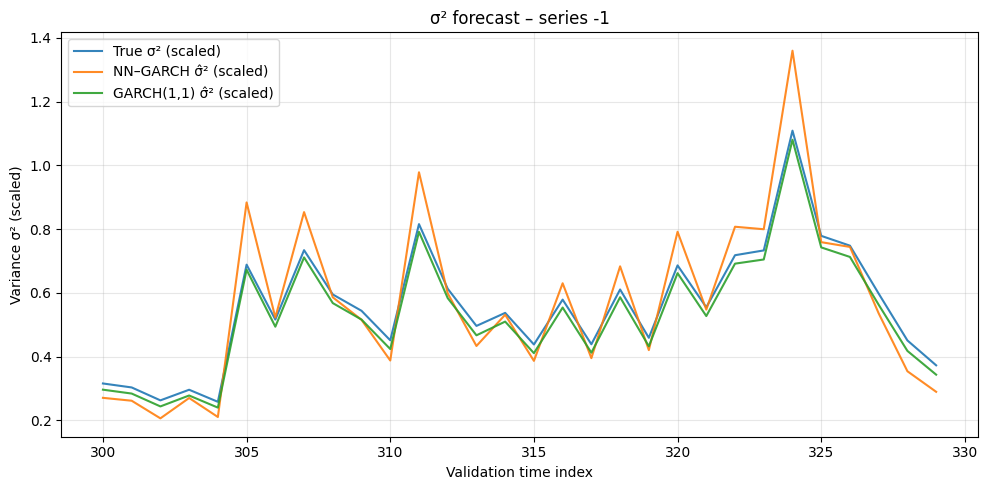

Saved NN vs ARCH forecast comparison to 'sigma2_forecast_nn_vs_arch_series0.png'


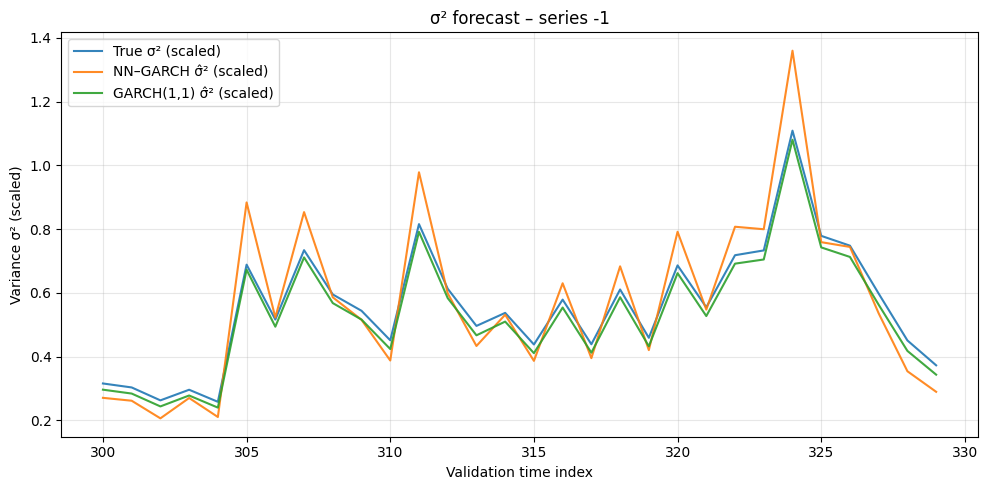


STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)

EXPERIMENT COMPLETED SUCCESSFULLY!

Key Achievements:
  ✓ NN approximates (scaled) GARCH parameters across many series
  ✓ Dynamic volatility layer captures time-varying variance on standardised returns
  ✓ Comparison NN–GARCH vs classical GARCH(1,1) on VALIDATION and TEST horizons

Generated Files:
  - training_curves.png
  - garch_multi_param_distributions.png
  - garch_multi_param_errors.png
  - garch_multi_param_scatter.png
  - garch_nn_vs_arch_param_errors.png
  - sigma2_forecast_nn_vs_arch_series0.png
  - alpha_train.png / alpha_val.png / alpha_test.png
  - beta_train.png / beta_val.png / beta_test.png
  - omega_train.png / omega_val.png / omega_test.png
  - best_garch_model_interpolation.pt (saved model weights)


In [49]:
# ============================================================================
# 10. MAIN EXAMPLE WITH FULL WORKFLOW
# ============================================================================

def main():
    """
    Complete workflow: Generate MULTI-SERIES GARCH data, train hybrid NN-GARCH model,
    and perform comprehensive multi-series evaluation.
    """
    print("=" * 80)
    print("HYBRID GARCH(1,1) + NEURAL NETWORK MODEL")
    print("Dynamic Volatility Layer with Parameter Learning (MULTI-SERIES)")
    print("Standardised returns + log-variance training")
    print("=" * 80)
    print()

    # ========== Configuration ==========
    N_SERIES   = 2000
    N_SAMPLES  = 2200
    TRAIN_SPLIT = 0.7
    VAL_SPLIT   = 0.15   # reste pour test
    TEST_SPLIT  = 1.0 - TRAIN_SPLIT - VAL_SPLIT

    # Time splits (en proportion de la longueur temporelle)
    train_len = int(TRAIN_SPLIT * N_SAMPLES)
    val_len   = int(VAL_SPLIT   * N_SAMPLES)
    test_len  = N_SAMPLES - train_len - val_len

    # ---------------------------------------------------------
    # TRUE PARAMETER SAMPLING — REAL EXTRAPOLATION
    # ---------------------------------------------------------
    N_TRAIN_SERIES = int(0.8 * N_SERIES)  # séries in-range (train/val)
    N_TEST_SERIES  = N_SERIES - N_TRAIN_SERIES  # séries extrapolation

    # TRAIN / VAL (IN-RANGE)
    OMEGAS_TRAIN = np.random.uniform(0.01, 0.1, size=N_TRAIN_SERIES)
    ALPHAS_TRAIN = np.random.uniform(0.20, 0.50, size=N_TRAIN_SERIES)
    BETAS_TRAIN  = np.random.uniform(0.05, 0.80, size=N_TRAIN_SERIES)

    mask_bad = (ALPHAS_TRAIN + BETAS_TRAIN) >= 0.99
    while np.any(mask_bad):
        BETAS_TRAIN[mask_bad] = np.random.uniform(0.05, 0.80, mask_bad.sum())
        mask_bad = (ALPHAS_TRAIN + BETAS_TRAIN) >= 0.99

    # TEST (EXTRAPOLATION)
    OMEGAS_TEST = np.random.uniform(0.01, 0.1, size=N_TEST_SERIES)
    ALPHAS_TEST = np.random.uniform(0.1, 0.20, size=N_TEST_SERIES)
    BETAS_TEST  = np.random.uniform(0.80, 0.97, size=N_TEST_SERIES)

    mask_bad = (ALPHAS_TEST + BETAS_TEST) >= 0.99
    while np.any(mask_bad):
        BETAS_TEST[mask_bad] = np.random.uniform(0.80, 0.97, mask_bad.sum())
        mask_bad = (ALPHAS_TEST + BETAS_TEST) >= 0.99

    # CONCATÉNATION finale (ordre : d'abord séries in-range, puis séries extrapolation)
    TRUE_OMEGAS = np.concatenate([OMEGAS_TRAIN, OMEGAS_TEST])
    TRUE_ALPHAS = np.concatenate([ALPHAS_TRAIN, ALPHAS_TEST])
    TRUE_BETAS  = np.concatenate([BETAS_TRAIN,  BETAS_TEST])

    print(f"Sampling random GARCH parameters for {N_SERIES} series...")
    print("Example (first 5):")
    for j in range(5):
        print(
            f"Series {j}: "
            f"omega={TRUE_OMEGAS[j]:.4f}, "
            f"alpha={TRUE_ALPHAS[j]:.4f}, "
            f"beta={TRUE_BETAS[j]:.4f}, "
            f"alpha+beta={TRUE_ALPHAS[j] + TRUE_BETAS[j]:.4f}"
        )

    # Model configuration
    WINDOW_SIZE = 300
    HIDDEN_DIM  = 128

    # Training configuration
    BATCH_SIZE    = 2048
    N_EPOCHS      = 10
    LEARNING_RATE = 1e-3

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}\n")

    # ========== Step 1: Generate GARCH Data Series ==========
    all_returns_list   = []
    all_variances_list = []

    for j in range(N_SERIES):
        generator = GARCHGenerator(
            omega=float(TRUE_OMEGAS[j]),
            alpha=float(TRUE_ALPHAS[j]),
            beta=float(TRUE_BETAS[j]),
            n_samples=N_SAMPLES,
            seed=42 + j  # different seed per series
        )

        returns_j, variances_j = generator.generate_series()
        all_returns_list.append(returns_j)
        all_variances_list.append(variances_j)

    # Stack into tensors: shape [N_SERIES, N_SAMPLES]
    all_returns   = torch.stack(all_returns_list,   dim=0)  # ORIGINAL scale
    all_variances = torch.stack(all_variances_list, dim=0)  # ORIGINAL σ²

    print(f"\nGenerated {N_SERIES} GARCH series:")
    print(f"  all_returns shape:   {all_returns.shape}")
    print(f"  all_variances shape: {all_variances.shape}")

    # ========== Step 1bis: Global standardisation of returns + rescale σ² ==========
    mean_r = all_returns.mean()
    std_r  = all_returns.std()
    std_r_f = float(std_r)

    all_returns   = (all_returns - mean_r) / (std_r + 1e-8)
    all_variances = all_variances / ((std_r + 1e-8) ** 2)

    print(f"\nStandardised returns globally:")
    print(f"  mean ≈ {float(all_returns.mean()):.4f}, std ≈ {float(all_returns.std()):.4f}")
    print(f"  Scale factor used (std of original returns): {std_r_f:.4f}")

    # On the standardised process, the true parameters become:
    # ω' = ω / std^2, α' = α, β' = β
    TRUE_OMEGAS_SCALED = TRUE_OMEGAS / (std_r_f ** 2)
    TRUE_ALPHAS_SCALED = TRUE_ALPHAS
    TRUE_BETAS_SCALED  = TRUE_BETAS

    # ======================================================================
    #  SPLIT SERIES BETWEEN IN-RANGE (train/val) AND EXTRAPOLATION (test)
    # ======================================================================
    # 80% séries pour training/validation (in-range)
    returns_inrange   = all_returns[:N_TRAIN_SERIES]
    variances_inrange = all_variances[:N_TRAIN_SERIES]

    # 20% séries pour extrapolation (test)
    returns_extrap    = all_returns[N_TRAIN_SERIES:]
    variances_extrap  = all_variances[N_TRAIN_SERIES:]

    # ======================================================================
    #  TIME SPLIT (ONLY FOR IN-RANGE SERIES)
    # ======================================================================
    train_returns_in   = returns_inrange[:, :train_len]
    train_variances_in = variances_inrange[:, :train_len]

    val_returns_in     = returns_inrange[:, train_len:train_len + val_len]
    val_variances_in   = variances_inrange[:, train_len:train_len + val_len]

    # ======================================================================
    #  EXTRAPOLATION SERIES: NO TRAIN/VAL SPLIT -> FULL SERIES USED AS TEST
    # ======================================================================
    test_returns_ex    = returns_extrap           # [N_TEST_SERIES, N_SAMPLES]
    test_variances_ex  = variances_extrap

    # ========== Step 2: Create Train/Val/Test datasets from ALL series ==========
    train_returns   = all_returns[:, :train_len]                       # [N_SERIES, train_len]
    train_variances = all_variances[:, :train_len]

    val_returns     = all_returns[:, train_len:train_len + val_len]    # [N_SERIES, val_len]
    val_variances   = all_variances[:, train_len:train_len + val_len]

    test_returns    = all_returns[:, train_len + val_len:]             # [N_SERIES, test_len]
    test_variances  = all_variances[:, train_len + val_len:]

    print(f"\nTrain time length: {train_len}")
    print(f"Val time length:   {val_len}")
    print(f"Test time length:  {test_len}")

    # ========= 2b. Fit classical GARCH(1,1) with arch_model on TRAIN only =========
    garch_omega_hat = np.zeros(N_SERIES)
    garch_alpha_hat = np.zeros(N_SERIES)
    garch_beta_hat  = np.zeros(N_SERIES)

    for j in range(N_SERIES):
        r_train = train_returns[j].numpy()   # shape [train_len], standardised
        am = arch_model(
            r_train,
            vol='GARCH',
            p=1,
            q=1,
            mean='Zero',
            dist='normal',
            rescale=False,    # IMPORTANT: avoid internal rescale
        )
        res = am.fit(disp='off')

        garch_omega_hat[j] = res.params['omega']
        garch_alpha_hat[j] = res.params['alpha[1]']
        garch_beta_hat[j]  = res.params['beta[1]']

    C_true = TRUE_ALPHAS_SCALED + TRUE_BETAS_SCALED
    C_arch = garch_alpha_hat + garch_beta_hat

    print("True C = α+β (mean/min/max):",
          C_true.mean(), C_true.min(), C_true.max())
    print("ARCH Ĉ = α̂+β̂ (mean/min/max):",
          C_arch.mean(), C_arch.min(), C_arch.max())

    print("omega true (scaled) mean/min/max:",
          TRUE_OMEGAS_SCALED.mean(), TRUE_OMEGAS_SCALED.min(), TRUE_OMEGAS_SCALED.max())
    print("omega_hat ARCH mean/min/max:",
          garch_omega_hat.mean(), garch_omega_hat.min(), garch_omega_hat.max())

    # ---------- Projection des paramètres ARCH dans le même domaine que le générateur ----------
    C_min, C_max = C_true.min(), C_true.max()
    C_hat = garch_alpha_hat + garch_beta_hat

    C_clipped = np.clip(C_hat, C_min, C_max)
    scale = C_clipped / (C_hat + 1e-8)
    garch_alpha_hat *= scale
    garch_beta_hat  *= scale

    C_arch_proj = garch_alpha_hat + garch_beta_hat
    print("ARCH Ĉ after projection (mean/min/max):",
          C_arch_proj.mean(), C_arch_proj.min(), C_arch_proj.max())

    # ========= Step 2c: Build PyTorch datasets and loaders =========
    # IN-RANGE (train/val) + EXTRAPOLATION (test)
    train_dataset = MultiGARCHDataset(train_returns_in, train_variances_in, WINDOW_SIZE)
    val_dataset   = MultiGARCHDataset(val_returns_in,   val_variances_in,   WINDOW_SIZE)
    test_dataset  = MultiGARCHDataset(test_returns_ex,  test_variances_ex,  WINDOW_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=4, pin_memory=True)

    print(f"\nTrain samples: {len(train_dataset)}")
    print(f"Val samples:   {len(val_dataset)}")
    print(f"Test samples:  {len(test_dataset)}")
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches:   {len(val_loader)}")

    # ========== Step 3: Initialize Model ==========
    print("\n" + "=" * 80)
    print("STEP 3: INITIALIZING HYBRID MODEL")
    print("=" * 80)

    model = HybridGARCHModel(input_seq_len=WINDOW_SIZE, hidden_dim=HIDDEN_DIM)
    model = model.to(device)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model architecture:")
    print(f"  Parameter Network: Conv1d → MLP → (ω, α, β)")
    print(f"  Volatility Layer:  GARCH(1,1) recursion")
    print(f"  Total trainable parameters: {total_params:,}")

    print(f"\nModel structure:")
    print(model)

    # ========== Step 4: Train Model ==========
    print("\n" + "=" * 80)
    print("STEP 4: TRAINING HYBRID MODEL")
    print("=" * 80)
    print(f"Epochs: {N_EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Optimizer: Adam with weight decay")
    print(f"Loss: MSE between predicted and true log-variance log(σ²)")
    print()

    history = train_hybrid_garch(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        device=device,
        checkpoint_path="best_garch_model_interpolation.pt",
        load_best=True,
    )

    # ======= SAUVEGARDE DU MODELE PRE-ENTRAINE SUR DONNEES SYNTHETIQUES =======
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "window_size": WINDOW_SIZE,
        "hidden_dim": HIDDEN_DIM,
        "mean_r": float(mean_r),
        "std_r": float(std_r),
        "n_series": N_SERIES,
        "n_samples": N_SAMPLES,
    }

    torch.save(checkpoint, "hybrid_garch_pretrained_synth.pt")
    print("\nSaved pretrained synthetic model to 'hybrid_garch_pretrained_synth.pt'")

    # ========== Step 5: Global Loss Summary ==========
    print("\n" + "=" * 80)
    print("STEP 5: GLOBAL TRAINING SUMMARY")
    print("=" * 80)

    print("\nLoss Summary (log-variance MSE):")
    print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
    print(f"  Final train loss:   {history['train_loss'][-1]:.6f}")
    print(f"  Final val loss:     {history['val_loss'][-1]:.6f}")
    print(f"  Loss reduction:     {(1 - history['train_loss'][-1] / history['train_loss'][0]) * 100:.2f}%")

    plot_training_curves(history, save_path="training_curves.png")

    # ========== Step 6: Multi-Series Visualizations (VALIDATION + TEST) ==========
    print("\n" + "=" * 80)
    print("STEP 6: MULTI-SERIES PARAMETER VISUALIZATION (VAL + TEST)")
    print("=" * 80)

    # Bloc 1 : metrics sur VALIDATION (in-range séries)
    metrics_val = create_visualizations_multi(
        model=model,
        val_dataset=val_dataset,         # MultiGARCHDataset (std scale, N_TRAIN_SERIES)
        true_omegas=TRUE_OMEGAS_SCALED[:N_TRAIN_SERIES],
        true_alphas=TRUE_ALPHAS_SCALED[:N_TRAIN_SERIES],
        true_betas=TRUE_BETAS_SCALED[:N_TRAIN_SERIES],
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat[:N_TRAIN_SERIES],
        garch_alphas=garch_alpha_hat[:N_TRAIN_SERIES],
        garch_betas=garch_beta_hat[:N_TRAIN_SERIES],
    )

    print("\nMulti-series metrics summary (VALIDATION, scaled σ²):")
    for k, v in metrics_val.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric (VAL): R² on σ²_t+1 (validation, scaled) = {metrics_val['val_r2']:.4f}")

    # Bloc 2 : metrics sur TEST (séries extrapolation)
    metrics_test = create_visualizations_multi(
        model=model,
        val_dataset=test_dataset,        # MultiGARCHDataset (std scale, N_TEST_SERIES)
        true_omegas=TRUE_OMEGAS_SCALED[N_TRAIN_SERIES:],
        true_alphas=TRUE_ALPHAS_SCALED[N_TRAIN_SERIES:],
        true_betas=TRUE_BETAS_SCALED[N_TRAIN_SERIES:],
        device=device,
        batch_size=BATCH_SIZE,
        garch_omegas=garch_omega_hat[N_TRAIN_SERIES:],
        garch_alphas=garch_alpha_hat[N_TRAIN_SERIES:],
        garch_betas=garch_beta_hat[N_TRAIN_SERIES:],
    )

    print("\nMulti-series metrics summary (TEST, scaled σ²):")
    for k, v in metrics_test.items():
        print(f"  {k}: {v:.6f}")
    print(f"\nKey OOS metric (TEST): R² on σ²_t+1 (test, scaled) = {metrics_test['val_r2']:.4f}")

    # ========== Step 6bis: Forecast comparison NN–GARCH vs classical GARCH(1,1) ==========
    print("\n" + "=" * 80)
    print("STEP 6bis: FORECAST COMPARISON NN–GARCH vs GARCH(1,1)")
    print("=" * 80)

    all_returns_np   = all_returns.numpy()      # [N_SERIES, N_SAMPLES], std
    all_variances_np = all_variances.numpy()    # [N_SERIES, N_SAMPLES], σ² std

    # σ̂²_t GARCH(1,1) pour toutes les séries / tous les t
    arch_sigma2_hat = np.zeros_like(all_returns_np)
    for j in range(N_SERIES):
        arch_sigma2_hat[j, :] = compute_garch_variance_from_params(
            returns=all_returns_np[j, :],
            omega=garch_omega_hat[j],
            alpha=garch_alpha_hat[j],
            beta=garch_beta_hat[j],
        )

    # ---------- Bloc VALIDATION ----------
    arch_val_sigma2 = arch_sigma2_hat[:, train_len:train_len + val_len]
    true_val_sigma2 = all_variances_np[:, train_len:train_len + val_len]

    targets_val = []
    arch_val    = []
    for j in range(N_SERIES):
        for t in range(val_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_val.append(true_val_sigma2[j, idx])   # vraie σ²_{t+1} (std)
            arch_val.append(arch_val_sigma2[j, idx])      # σ̂²_{t+1} GARCH (std)

    targets_val = np.array(targets_val)
    arch_val    = np.array(arch_val)

    mse_arch_val = np.mean((arch_val - targets_val)**2)
    mae_arch_val = np.mean(np.abs(arch_val - targets_val))
    r2_arch_val  = np.corrcoef(targets_val, arch_val)[0, 1]**2

    print("\n[VALIDATION set — σ²_{t+1}, standardised process]")
    print(f"  NN–GARCH   MSE = {metrics_val['val_mse']:.4e}, "
          f"MAE = {metrics_val['val_mae']:.4e}, "
          f"R² = {metrics_val['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch_val:.4e}, "
          f"MAE = {mae_arch_val:.4e}, "
          f"R² = {r2_arch_val:.4f}")

    sigma_true_val = np.sqrt(np.clip(targets_val, 1e-12, None))
    sigma_arch_val = np.sqrt(np.clip(arch_val,    1e-12, None))
    mse_sigma_arch_val = np.mean((sigma_arch_val - sigma_true_val)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (VAL, std): {mse_sigma_arch_val:.4e}")

    # ---------- Bloc TEST ----------
    arch_test_sigma2 = arch_sigma2_hat[:, train_len + val_len:]
    true_test_sigma2 = all_variances_np[:, train_len + val_len:]

    targets_test = []
    arch_test    = []
    for j in range(N_SERIES):
        for t in range(test_len - WINDOW_SIZE):
            idx = t + WINDOW_SIZE
            targets_test.append(true_test_sigma2[j, idx])   # vraie σ²_{t+1} (std)
            arch_test.append(arch_test_sigma2[j, idx])      # σ̂²_{t+1} GARCH (std)

    targets_test = np.array(targets_test)
    arch_test    = np.array(arch_test)

    mse_arch_test = np.mean((arch_test - targets_test)**2)
    mae_arch_test = np.mean(np.abs(arch_test - targets_test))
    r2_arch_test  = np.corrcoef(targets_test, arch_test)[0, 1]**2

    print("\n[TEST set — σ²_{t+1}, standardised process]")
    print(f"  NN–GARCH   MSE = {metrics_test['val_mse']:.4e}, "
          f"MAE = {metrics_test['val_mae']:.4e}, "
          f"R² = {metrics_test['val_r2']:.4f}")
    print(f"  GARCH(1,1) MSE = {mse_arch_test:.4e}, "
          f"MAE = {mae_arch_test:.4e}, "
          f"R² = {r2_arch_test:.4f}")

    sigma_true_test = np.sqrt(np.clip(targets_test, 1e-12, None))
    sigma_arch_test = np.sqrt(np.clip(arch_test,    1e-12, None))
    mse_sigma_arch_test = np.mean((sigma_arch_test - sigma_true_test)**2)
    print(f"  GARCH(1,1) MSE on σ_(t+1) (TEST, std): {mse_sigma_arch_test:.4e}")

    # ========== Step 6ter: Visual comparison of σ² forecasts on one series ==========
    plot_forecast_comparison_nn_vs_arch(
      model=model,
      val_returns=val_returns,             # torch.Tensor [N_SERIES, val_len] std
      true_val_sigma2=true_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
      arch_val_sigma2=arch_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
      window_size=WINDOW_SIZE,
      device=device,
      series_idx=-1,
      save_path="sigma2_forecast_nn_vs_arch_series0.png",
    )

    plot_forecast_comparison_nn_vs_arch(
        model=model,
        val_returns=val_returns,             # torch.Tensor [N_SERIES, val_len] std
        true_val_sigma2=true_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        arch_val_sigma2=arch_val_sigma2,     # np.ndarray   [N_SERIES, val_len] std
        window_size=WINDOW_SIZE,
        device=device,
        series_idx=-1,
        save_path="sigma2_forecast_nn_vs_arch_series0.png",
    )

    # ========== Step 7: α_true vs α_pred plots for TRAIN / VAL / TEST ==========
    print("\n" + "=" * 80)
    print("STEP 7: α TRUE vs α PRED (TRAIN / VAL / TEST)")
    print("=" * 80)

    omega_hat_train, alpha_hat_train, beta_hat_train = collect_parameters_per_series(
        model, train_dataset, device, batch_size=BATCH_SIZE
    )
    omega_hat_val, alpha_hat_val, beta_hat_val = collect_parameters_per_series(
        model, val_dataset, device, batch_size=BATCH_SIZE
    )
    omega_hat_test, alpha_hat_test, beta_hat_test = collect_parameters_per_series(
        model, test_dataset, device, batch_size=BATCH_SIZE
    )

    # TRUE parameters subsets
    TRUE_ALPHAS_TRAIN = TRUE_ALPHAS_SCALED[:N_TRAIN_SERIES]
    TRUE_ALPHAS_TEST  = TRUE_ALPHAS_SCALED[N_TRAIN_SERIES:]
    TRUE_OMEGAS_TRAIN = TRUE_OMEGAS_SCALED[:N_TRAIN_SERIES]
    TRUE_BETAS_TRAIN  = TRUE_BETAS_SCALED[:N_TRAIN_SERIES]

    TRUE_OMEGAS_TEST = TRUE_OMEGAS_SCALED[N_TRAIN_SERIES:]
    TRUE_BETAS_TEST  = TRUE_BETAS_SCALED[N_TRAIN_SERIES:]

    # Plots α
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TRAIN, alpha_hat_train,
        "Train (in-range α)", "alpha_train.png", param_name="alpha"
    )
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TRAIN, alpha_hat_val,
        "Validation (in-range α)", "alpha_val.png", param_name="alpha"
    )
    plot_param_true_vs_pred(
        TRUE_ALPHAS_TEST, alpha_hat_test,
        "Test (extrapolation α)", "alpha_test.png", param_name="alpha"
    )

    # Plots β
    plot_param_true_vs_pred(
        TRUE_BETAS_TRAIN, beta_hat_train,
        "Train (in-range β)", "beta_train.png", param_name="beta"
    )
    plot_param_true_vs_pred(
        TRUE_BETAS_TRAIN, beta_hat_val,
        "Validation (in-range β)", "beta_val.png", param_name="beta"
    )
    plot_param_true_vs_pred(
        TRUE_BETAS_TEST, beta_hat_test,
        "Test (extrapolation β)", "beta_test.png", param_name="beta"
    )

    # Plots ω
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TRAIN, omega_hat_train,
        "Train (in-range ω)", "omega_train.png", param_name="omega"
    )
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TRAIN, omega_hat_val,
        "Validation (in-range ω)", "omega_val.png", param_name="omega"
    )
    plot_param_true_vs_pred(
        TRUE_OMEGAS_TEST, omega_hat_test,
        "Test (extrapolation ω)", "omega_test.png", param_name="omega"
    )

    # ========== Summary ==========
    print("\n" + "=" * 80)
    print("EXPERIMENT COMPLETED SUCCESSFULLY!")
    print("=" * 80)
    print("\nKey Achievements:")
    print("  ✓ NN approximates (scaled) GARCH parameters across many series")
    print("  ✓ Dynamic volatility layer captures time-varying variance on standardised returns")
    print("  ✓ Comparison NN–GARCH vs classical GARCH(1,1) on VALIDATION and TEST horizons")
    print("\nGenerated Files:")
    print("  - training_curves.png")
    print("  - garch_multi_param_distributions.png")
    print("  - garch_multi_param_errors.png")
    print("  - garch_multi_param_scatter.png")
    print("  - garch_nn_vs_arch_param_errors.png")
    print("  - sigma2_forecast_nn_vs_arch_series0.png")
    print("  - alpha_train.png / alpha_val.png / alpha_test.png")
    print("  - beta_train.png / beta_val.png / beta_test.png")
    print("  - omega_train.png / omega_val.png / omega_test.png")
    print("  - best_garch_model_interpolation.pt (saved model weights)")
    print("=" * 80)


main()
